In [1]:
import urllib.request
from datetime import datetime
import dateutil
import re, os, shutil, logging, json, functools

import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
from scipy.optimize import curve_fit

from ts_viz import TimeSeriesViz

In [2]:
!mkdir -p figures
!mkdir -p data

In [3]:
def rolling_mean(df, window=7, extend=True, center=True):
    return df.rolling(window=window, center=center, min_periods=(window // 2) if extend else window).mean()

In [4]:
import functools

def lazyprop(fn):
    attr_name = '_lazy_' + fn.__name__

    @property
    @functools.wraps(fn)
    def _lazyprop(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, fn(self))
        return getattr(self, attr_name)

    return _lazyprop

class DataSet:

    def __init__(self, path, repo='pcm-dpc/COVID-19', date_cols=['data'], index_cols=['data'], resample=False):
        self.repo = repo
        self.path = path
        self.commit_url = f'https://api.github.com/repos/{self.repo}/commits?path={self.path}&page=1&per_page=1'
        self.data_url = f'https://raw.githubusercontent.com/{self.repo}/master/{self.path}'
        self.resample = resample
        self.date_cols = date_cols
        self.index_cols = index_cols
    
    @lazyprop
    def last_modified(self):
        with urllib.request.urlopen(self.commit_url) as url:
            data = json.loads(url.read().decode())
            date = data[0]['commit']['committer']['date']
            utc_date = dateutil.parser.parse(date)
            return utc_date.astimezone(dateutil.tz.gettz('Italy/Rome'))

    @lazyprop
    def df(self):
        df = pd.read_csv(self.data_url, parse_dates=self.date_cols, index_col=self.index_cols)
        if self.resample:
            df = df.resample('D').last()
        return df
        
    def __repr__(self):
        return (f'DataSet\n  repo: {self.repo}\n  path: {self.path}\n  commit_url: {self.commit_url}\n'
                f'  last_modified: {self.last_modified}\n  data_url: {self.data_url}\n  df: {len(self.df)} items')



In [5]:
def show_cases(cases_df, pop, title='Casi', figsize=(16, 10)):
    columns = ['deceduti', 'terapia_intensiva', 'ricoverati_con_sintomi', 
               'isolamento_domiciliare', 'dimessi_guariti']
    colors = ['tab:purple', 'tab:red', 'tab:orange', 'tab:blue', 'tab:green']
    data = cases_df[columns] / pop
    ax = data.plot(kind='area', title=title, color=colors, figsize=figsize)
#     fig, ax = plt.subplots(figsize=figsize)
#     ax.stackplot(cases_df.index, cases_df[columns].T, colors=colors)
    ax.set_title(title)
    ax.xaxis.grid(True, which='major')
    ax.yaxis.grid(True, which='major')
    locator = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.xaxis.set_label_text('')
    ax.axhline(0.0, linewidth=2, color='white')
    ax.legend()
    return ax

In [6]:
class Regional:
    
    def __init__(self, figures_path=None):
        self.figures_path = figures_path
        self.dataset = DataSet('dati-regioni/dpc-covid19-ita-regioni.csv')
        self.reg_pop = pd.read_csv('data/popolazione_regioni.csv', names=['region', 'population'], 
                                   index_col='region')
        if self.figures_path:
            self.cases_path = os.path.join(self.figures_path, 'cases')
            os.makedirs(self.cases_path, exist_ok=True)
        else:
            self.cases_path = None
    
    @staticmethod
    def slug(region):
        return re.sub("\W", '', region).lower()
    
    def cases_figure_filename(self, region_name, last_modified=True):
        if not self.cases_path:
            return None
        filename_elems = [Regional.slug(region_name)]
        if last_modified:
            filename_elems.append(f'{self.dataset.last_modified:%Y%m%d}')
        filename = '-'.join(filename_elems) + '.png'
        return os.path.join(self.cases_path, filename)
    
    def total_cases_figure_filename(self, last_modified=True):
        if not self.cases_path:
            return None
        filename_elems = ['00-total']
        if last_modified:
            filename_elems.append(f'{self.dataset.last_modified:%Y%m%d}')
        filename = '-'.join(filename_elems) + '.png'
        return os.path.join(self.cases_path, filename)
    
    def save_figure(self, filenames, show=True, close=True):
        if filenames:
            plt.savefig(filenames[0])
            for filename in filenames[1:]:
                shutil.copyfile(filenames[0], filename)
        if show:
            plt.show()
        if close:
            plt.close()

    def cases_figure(self, region_name, show=False, ylim=(-1200, 500), figsize=(16, 10)):
        cases_df = self.dataset.df[self.dataset.df['denominazione_regione'] == region_name]
        cases_df = cases_df.resample('D').last()
        cases_df['deceduti'] = -cases_df['deceduti']
        cases_df['dimessi_guariti'] = -cases_df['dimessi_guariti']
        pop = self.reg_pop.at[region_name, 'population'] / 100000
        ax = show_cases(cases_df, pop, 
                        title=f'Casi per 100.000 persone nella regione di {region_name}\n'
                              f'(dati aggiornati: {self.dataset.last_modified:%d/%m/%Y %H:%M:%S})', 
                        figsize=figsize)
        ax.set_ylim(ylim)
        filenames = []
        fn_date = self.cases_figure_filename(region_name)
        if fn_date:
            filenames.append(fn_date)
        fn_last = self.cases_figure_filename(region_name, last_modified=False)
        if fn_last:
            filenames.append(fn_last)
        ax.xaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='major')
        locator = mdates.MonthLocator(interval=1)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        ax.legend(loc='upper left')
        self.save_figure(filenames, show)
    
    def region_names(self):
        return self.dataset.df['denominazione_regione'].unique()
    
    def all_regions_cases_figure(self, show_regions=[], ylim=(-1200, 500), figsize=(16, 10)):
        for region_name in show_regions:
            self.cases_figure(region_name, show=(region_name in show_regions), ylim=ylim, figsize=figsize)

    def regional_totals(self, per_population=False, column='totale_casi', diff=1, window=7):
        regional_totals = self.dataset.df.pivot(columns='denominazione_regione', values=column)
        regional_totals['Trentino-Alto Adige'] = \
            regional_totals['P.A. Bolzano'] + regional_totals['P.A. Trento']
        regional_totals = regional_totals.drop(['P.A. Bolzano', 'P.A. Trento'], axis='columns')
        regional_totals = regional_totals[sorted(regional_totals.columns)]
        regional_totals = regional_totals.resample('D').last()
        if per_population:
            regional_totals = regional_totals.div(self.reg_pop['population']) * 100000
        if diff:
            regional_totals = (regional_totals - regional_totals.shift(diff)).clip(0, None)
        regional_totals = rolling_mean(regional_totals, window, extend=False).dropna()
        regional_totals = regional_totals.sort_values(axis='columns', by=regional_totals.index[-1], 
                                                      ascending=False)
        return regional_totals
            
    def total_cases_figure(self, show=True, per_population=False, column='totale_casi', diff=1, window=7, 
                           ylim=(0, None), xlim=(None, None), figsize=(16, 10)):
        regional_totals = self.regional_totals(per_population, column, diff, window)
        plot_title = f'{column} {"nuovi nei ultimi " + str(diff) + " giorni" if diff else "casi"} ' \
                     f'{"per 100.000 persone " if per_population else ""}' \
                     f'in Italia per regione\n' \
                     f'(dati aggiornati: {self.dataset.last_modified:%d/%m/%Y %H:%M:%S})'
        fig, ax = plt.subplots(figsize=figsize)
        linestyles = ['-', '--']
        if per_population:
            for idx, region in enumerate(regional_totals.columns):
                ax.plot(regional_totals.index, regional_totals[region], label=region, ls=linestyles[idx//10])
            ax.set_title(plot_title)
        else:
            ax = regional_totals.plot(kind='line' if per_population else 'area', figsize=figsize, 
                                      title=plot_title)

        ax.xaxis.grid(True, which='major')
        ax.yaxis.grid(True, which='major')
        locator = mdates.WeekdayLocator(byweekday=mdates.MO)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
        ax.xaxis.set_label_text('')
        ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.legend(title=None, ncol=2)
        filenames = []
        fn_date = self.total_cases_figure_filename()
        if fn_date:
            filenames.append(fn_date)
        fn_last = self.total_cases_figure_filename(last_modified=False)
        if fn_last:
            filenames.append(fn_last)
        self.save_figure(filenames, show)

In [7]:
# func = lambda x, a, b: a * np.exp(b * x) 
# func_name = 'exp'

func = lambda t, K, x, t0, b: K * np.power(t, x) * np.exp(-t / t0) + b
func_name = 'power'

def show_fit(series, func, func_name, title=None, pred=7, figsize=(10, 6), log=False, ax=None, window=None,
             fit_color = 'tab:red', ma_color = 'tab:orange'):
    x = np.arange(len(series))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        popt, pcov = curve_fit(func, x, series.values, p0=(1, 1, 5, 0), maxfev=5000)
    index = pd.date_range(series.index.min(), periods=(len(series) + pred), freq='D')
    y = func(np.arange(len(index)), *popt)
    fit = pd.Series(y, index=index)
    
    err = np.sqrt(np.sum((fit[:-pred] - series) ** 2) / len(series))
    print(f'Fit error: {err:.02f}')
    
    print(f'Predicted volume error: {1 - fit[:-pred].sum() / series.sum():.02%}')
    
    lw = 3
    
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(index, y, label=f'{func_name} fit', color=fit_color, lw=lw)
    ax.bar(series.index, series, label=series.name)
    argmax = index[np.argmax(fit)]
    ax.axvline(argmax, color=fit_color, lw=lw)
    if window:
        series_ma = series.rolling(window=window, center=True).mean()
        ax.plot(series_ma.index, series_ma, label=f'media mobile ({window} giorni)', color=ma_color, lw=lw)
    
    locator = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.yaxis.grid(True, which='major')
    if log:
        ax.set_yscale('log')
        ax.set_ylim((0.1, series.max() * 1.1))
    else:
        ax.set_ylim((0, None))
    if title:
        ax.set_title(title)
    plt.legend(loc='upper left')
    return popt, pcov, fit, argmax

# Casi regionali

In [8]:
regional_ds = DataSet('dati-regioni/dpc-covid19-ita-regioni.csv')
print(regional_ds)
regional_ds.df[regional_ds.df['denominazione_regione'] == 'Lombardia'].tail(n=10)
print(regional_ds.df['denominazione_regione'].unique())

DataSet
  repo: pcm-dpc/COVID-19
  path: dati-regioni/dpc-covid19-ita-regioni.csv
  commit_url: https://api.github.com/repos/pcm-dpc/COVID-19/commits?path=dati-regioni/dpc-covid19-ita-regioni.csv&page=1&per_page=1
  last_modified: 2021-02-07 16:57:13+01:00
  data_url: https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv
  df: 7350 items
['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'P.A. Bolzano' 'P.A. Trento' 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia'
 'Toscana' 'Umbria' "Valle d'Aosta" 'Veneto']


In [9]:
national = DataSet('dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv', resample=True)
print(national)
national.df.tail(n=10)

DataSet
  repo: pcm-dpc/COVID-19
  path: dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv
  commit_url: https://api.github.com/repos/pcm-dpc/COVID-19/commits?path=dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv&page=1&per_page=1
  last_modified: 2021-02-07 16:57:13+01:00
  data_url: https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv
  df: 350 items


stato  ricoverati_con_sintomi  terapia_intensiva  \
data                                                          
2021-01-29   ITA                   20397               2270   
2021-01-30   ITA                   20098               2218   
2021-01-31   ITA                   20096               2215   
2021-02-01   ITA                   20260               2252   
2021-02-02   ITA                   20317               2214   
2021-02-03   ITA                   20071               2145   
2021-02-04   ITA                   19743               2151   
2021-02-05   ITA                   19575               2142   
2021-02-06   ITA                   19408               2110   
2021-02-07   ITA                   19266               2107   

            totale_ospedalizzati  isolamento_domiciliare  totale_positivi  \
data                                                                        
2021-01-29                 22667                  445157           467824   
2021-01-30                 22316                  441036           463352   
2021-01-31                 22311                  431657           453968   
2021-02-01                 22512                  425077           447589   
2021-02-02                 22531                  415234           437765   
2021-02-03                 22216                  412506           434722   
2021-02-04                 21894                  408383           430277   
2021-02-05                 21717                  407401           429118   
2021-02-06                 21518                  405516           427034   
2021-02-07                 21373                  405651           427024   

            variazione_totale_positivi  nuovi_positivi  dimessi_guariti  \
data                                                                      
2021-01-29                       -6793           13574          1973388   
2021-01-30                       -4472           12715          1990152   
2021-01-31                       -9384           11252          2010548   
2021-02-01                       -6379            7925          2024523   
2021-02-02                       -9824            9660          2043500   
2021-02-03                       -3043           13189          2059248   
2021-02-04                       -4445           13659          2076928   
2021-02-05                       -1159           14218          2091923   
2021-02-06                       -2084           13442          2107061   
2021-02-07                         -10           11641          2118441   

            deceduti  ...   tamponi  casi_testati  note  \
data                  ...                                 
2021-01-29     87858  ...  32155352    16834157.0   NaN   
2021-01-30     88279  ...  32453362    16923532.0   NaN   
2021-01-31     88516  ...  32666726    17005122.0   NaN   
2021-02-01     88845  ...  32809145    17053960.0   NaN   
2021-02-02     89343  ...  33053574    17129160.0   NaN   
2021-02-03     89819  ...  33332881    17222062.0   NaN   
2021-02-04     90241  ...  33603023    17315499.0   NaN   
2021-02-05     90618  ...  33873530    17411746.0   NaN   
2021-02-06     91003  ...  34155937    17626494.0   NaN   
2021-02-07     91273  ...  34362726    17702105.0   NaN   

            ingressi_terapia_intensiva  note_test note_casi  \
data                                                          
2021-01-29                       148.0        NaN       NaN   
2021-01-30                       132.0        NaN       NaN   
2021-01-31                        97.0        NaN       NaN   
2021-02-01                       145.0        NaN       NaN   
2021-02-02                       158.0        NaN       NaN   
2021-02-03                       133.0        NaN       NaN   
2021-02-04                       147.0        NaN       NaN   
2021-02-05                       132.0        NaN       NaN   
2021-02-06                       144.0        NaN       NaN   
2021-02-07                

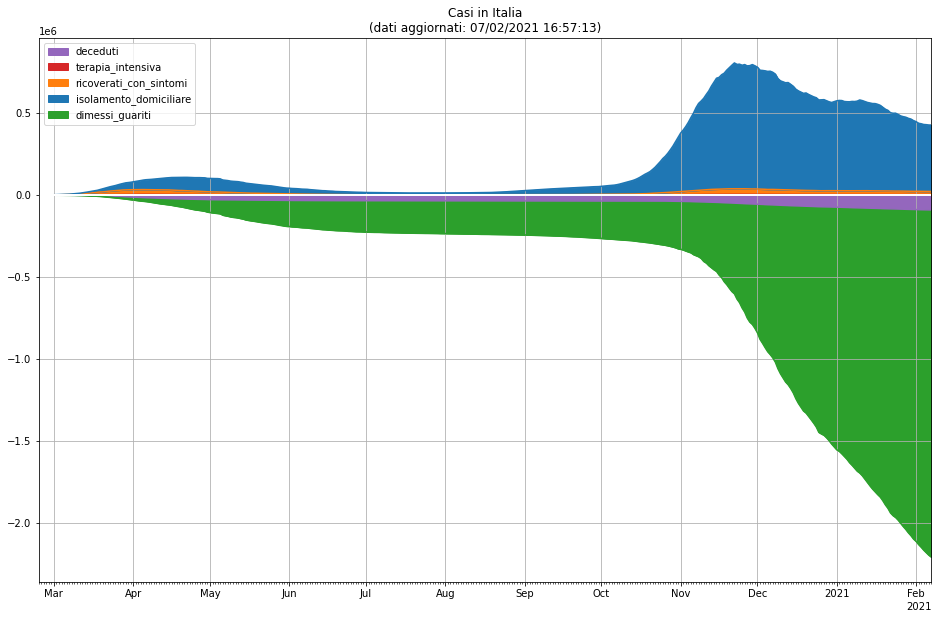

In [10]:
national_df = national.df.resample('D').last()
national_df['deceduti'] = -national_df['deceduti']
national_df['dimessi_guariti'] = -national_df['dimessi_guariti']
show_cases(national_df, 1, title=f'Casi in Italia\n'
           f'(dati aggiornati: {national.last_modified:%d/%m/%Y %H:%M:%S})', figsize=(16, 10))
plt.show()

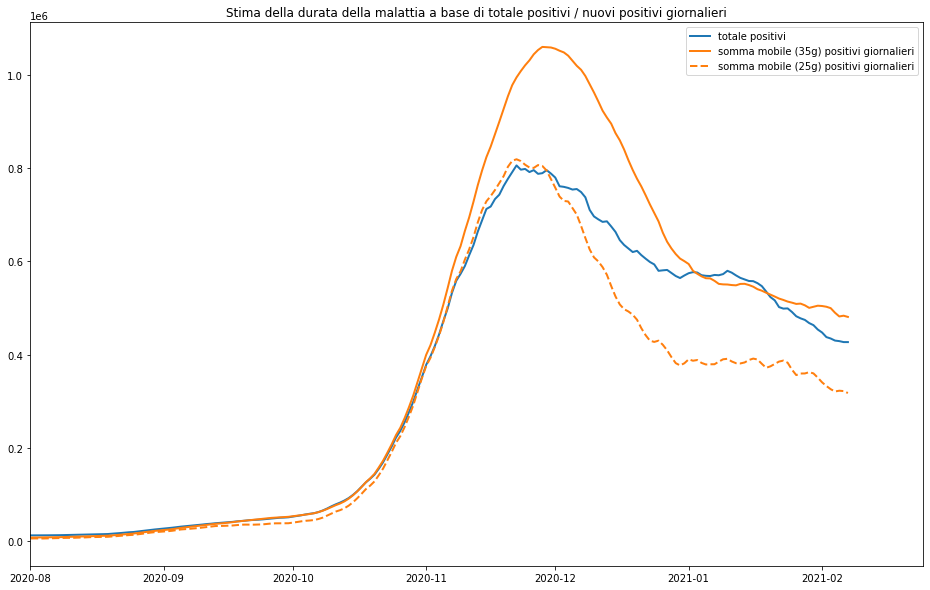

In [11]:
days = 35
fig, ax = plt.subplots(figsize=(16, 10))
pos = national_df['totale_positivi']
ax.plot(pos.index, pos, label=f'totale positivi', color='tab:blue', lw=2)

def plot_rol(days, color, ls='-'):
    rol = national_df['nuovi_positivi'].rolling(window=days).sum()
    ax.plot(rol.index, rol, label=f'somma mobile ({days}g) positivi giornalieri', color=color, lw=2, ls=ls)

plot_rol(35, 'tab:orange')
plot_rol(25, 'tab:orange', '--')
ax.legend()
ax.set_title('Stima della durata della malattia a base di totale positivi / nuovi positivi giornalieri')
ax.set_xlim(('2020-08-01', None))
plt.show()

In [12]:
def showdiff(df, diff=1, n=10):
    return (df - df.shift(diff)).tail(n=n)

In [13]:
national_df['totale_positivi'].tail(n=10)

data
2021-01-29    467824
2021-01-30    463352
2021-01-31    453968
2021-02-01    447589
2021-02-02    437765
2021-02-03    434722
2021-02-04    430277
2021-02-05    429118
2021-02-06    427034
2021-02-07    427024
Freq: D, Name: totale_positivi, dtype: int64

In [14]:
showdiff(national_df['totale_positivi'])

data
2021-01-29   -6793.0
2021-01-30   -4472.0
2021-01-31   -9384.0
2021-02-01   -6379.0
2021-02-02   -9824.0
2021-02-03   -3043.0
2021-02-04   -4445.0
2021-02-05   -1159.0
2021-02-06   -2084.0
2021-02-07     -10.0
Freq: D, Name: totale_positivi, dtype: float64

In [15]:
national_df['totale_casi'].tail(n=10)

data
2021-01-29    2529070
2021-01-30    2541783
2021-01-31    2553032
2021-02-01    2560957
2021-02-02    2570608
2021-02-03    2583790
2021-02-04    2597446
2021-02-05    2611659
2021-02-06    2625098
2021-02-07    2636738
Freq: D, Name: totale_casi, dtype: int64

In [16]:
showdiff(national_df['totale_casi'])

data
2021-01-29    13563.0
2021-01-30    12713.0
2021-01-31    11249.0
2021-02-01     7925.0
2021-02-02     9651.0
2021-02-03    13182.0
2021-02-04    13656.0
2021-02-05    14213.0
2021-02-06    13439.0
2021-02-07    11640.0
Freq: D, Name: totale_casi, dtype: float64

In [17]:
-national_df['deceduti'].tail()

data
2021-02-03    89819
2021-02-04    90241
2021-02-05    90618
2021-02-06    91003
2021-02-07    91273
Freq: D, Name: deceduti, dtype: int64

In [18]:
showdiff(national_df['casi_testati'], n=20)

data
2021-01-19     71881.0
2021-01-20     92244.0
2021-01-21     95360.0
2021-01-22     82194.0
2021-01-23     87519.0
2021-01-24     76297.0
2021-01-25     50925.0
2021-01-26     73626.0
2021-01-27     88275.0
2021-01-28     96755.0
2021-01-29     81172.0
2021-01-30     89375.0
2021-01-31     81590.0
2021-02-01     48838.0
2021-02-02     75200.0
2021-02-03     92902.0
2021-02-04     93437.0
2021-02-05     96247.0
2021-02-06    214748.0
2021-02-07     75611.0
Freq: D, Name: casi_testati, dtype: float64

In [19]:
regional = Regional()
regional.dataset.df[regional_ds.df['denominazione_regione'] == 'Lombardia'].tail()

stato  codice_regione denominazione_regione        lat  \
data                                                                         
2021-02-03 17:00:00   ITA               3             Lombardia  45.466794   
2021-02-04 17:00:00   ITA               3             Lombardia  45.466794   
2021-02-05 17:00:00   ITA               3             Lombardia  45.466794   
2021-02-06 17:00:00   ITA               3             Lombardia  45.466794   
2021-02-07 17:00:00   ITA               3             Lombardia  45.466794   

                         long  ricoverati_con_sintomi  terapia_intensiva  \
data                                                                       
2021-02-03 17:00:00  9.190347                    3554                359   
2021-02-04 17:00:00  9.190347                    3539                362   
2021-02-05 17:00:00  9.190347                    3549                359   
2021-02-06 17:00:00  9.190347                    3540                354   
2021-02-07 17:00:00  9.190347                    3467                358   

                     totale_ospedalizzati  isolamento_domiciliare  \
data                                                                
2021-02-03 17:00:00                  3913                   43432   
2021-02-04 17:00:00                  3901                   42995   
2021-02-05 17:00:00                  3908                   44294   
2021-02-06 17:00:00                  3894                   44415   
2021-02-07 17:00:00                  3825                   45015   

                     totale_positivi  ...  note  ingressi_terapia_intensiva  \
data                                  ...                                     
2021-02-03 17:00:00            47345  ...   NaN                        20.0   
2021-02-04 17:00:00            46896  ...   NaN                        29.0   
2021-02-05 17:00:00            48202  ...   NaN                        15.0   
2021-02-06 17:00:00            48309  ...   NaN                        22.0   
2021-02-07 17:00:00            48840  ...   NaN                        14.0   

                     note_test  note_casi  totale_positivi_test_molecolare  \
data                                                                         
2021-02-03 17:00:00        NaN        NaN                         540016.0   
2021-02-04 17:00:00        NaN        NaN                         541623.0   
2021-02-05 17:00:00        NaN        NaN                         543996.0   
2021-02-06 17:00:00        NaN        NaN                         545694.0   
2021-02-07 17:00:00        NaN        NaN                         547114.0   

                     totale_positivi_test_antigenico_rapido  \
data                                                          
2021-02-03 17:00:00                                  1781.0   
2021-02-04 17:00:00                                  1920.0   
2021-02-05 17:00:00                                  2051.0   
2021-02-06 17:00:00                                  2276.0   
2021-02-07 17:00:00                                  2371.0   

                     tamponi_test_molecolare  tamponi_test_antigenico_rapido  \
data                                                                           
2021-02-03 17:00:00                5586597.0                        157317.0   
2021-02-04 17:00:00                5611029.0                        165932.0   
2021-02-05 17:00:00                5640491.0                        175473.0   
2021-02-06 17:00:00                5665314.0                        186742.0   
2021-02-07 17:00:00                5687920.0                        191760.0   

                     codice_nuts_1 codice_nuts_2  
data                                              
2021-02-03 17:00:00            ITC          ITC4  
2021-02-04 17:00:00            ITC          ITC4  
2021-02-05 17:00:00            ITC          ITC4  
2021-02-06 17:00:00            ITC          ITC4  
2021-02-07 17:00:00            ITC          IT

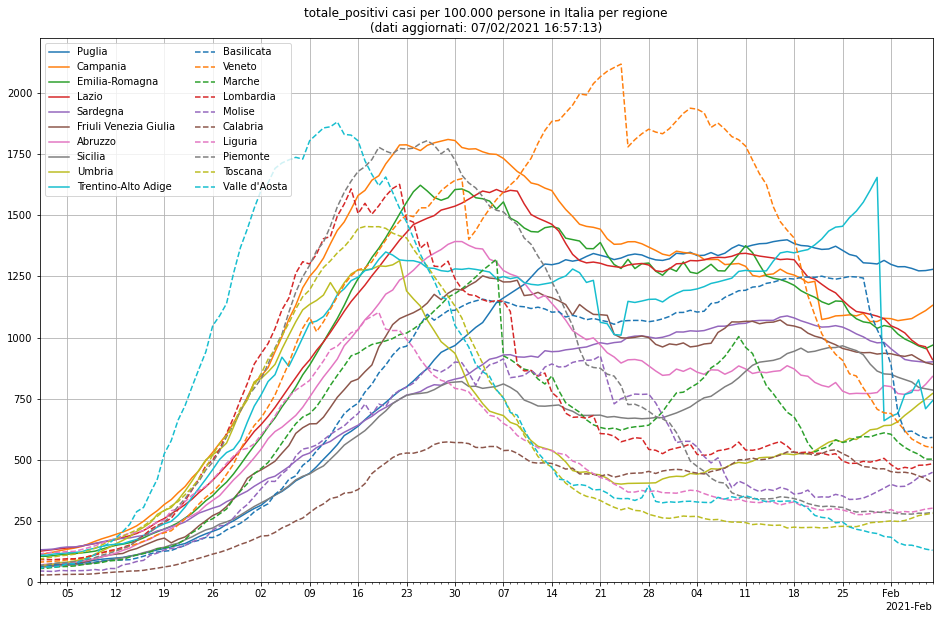

In [20]:
last_date = regional.dataset.df.index.max()
regional.total_cases_figure(per_population=True, column='totale_positivi', 
                            diff=False, xlim=('2020-10-01', last_date.strftime('%Y-%m-%d')), window=1)
plt.show()

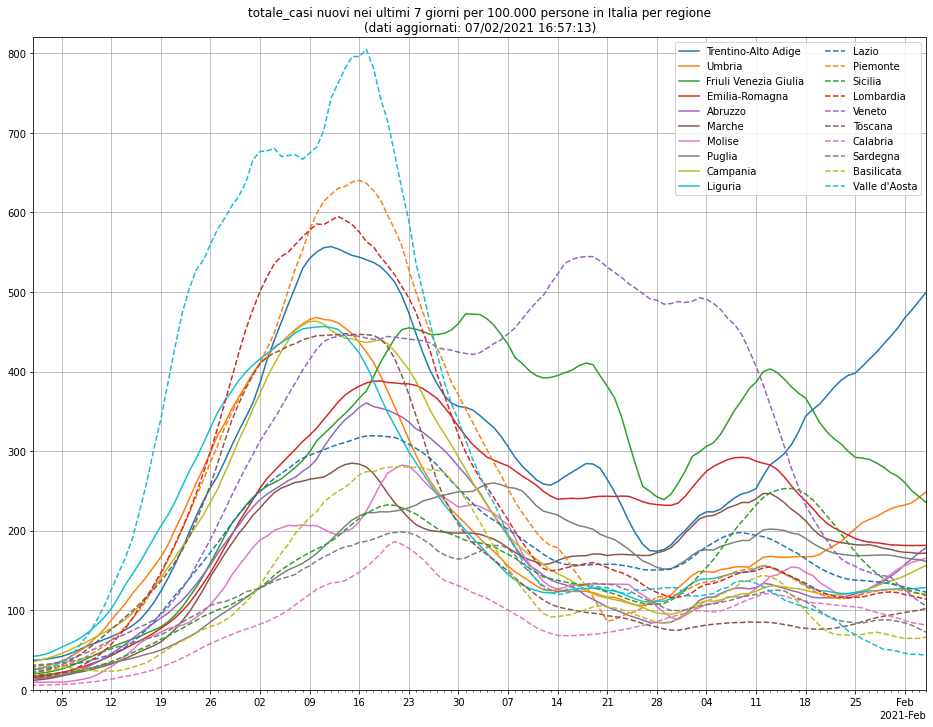

In [21]:
window = 7
case_last_date = (last_date - pd.Timedelta(days=window // 2)).strftime('%Y-%m-%d')
regional.total_cases_figure(column='totale_casi', xlim=('2020-10-01', case_last_date), ylim=(0, 820),
                            diff=7, per_population=True, window=window, figsize=(16, 12))
plt.show()

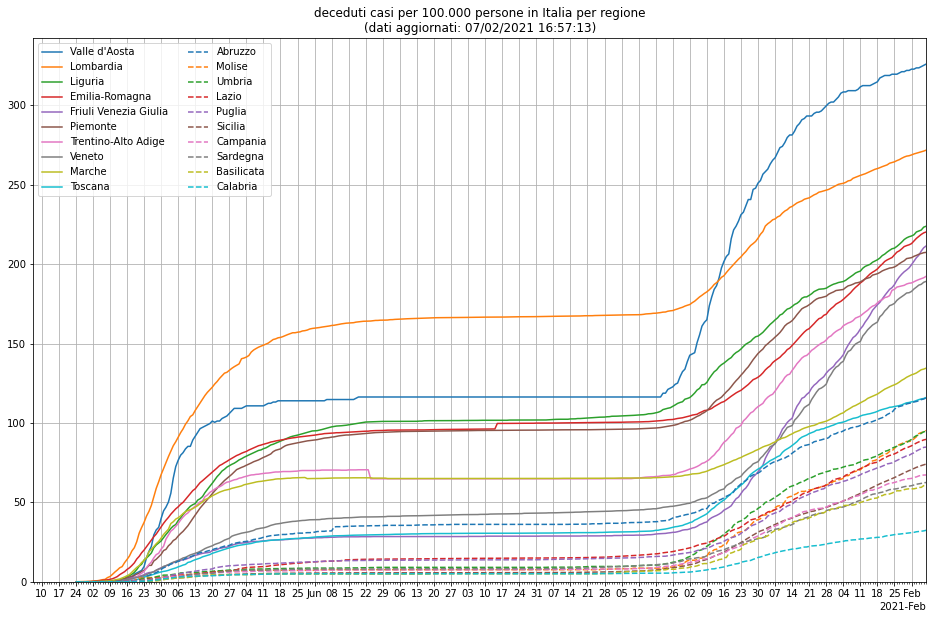

In [22]:
last_date = regional.dataset.df.index.max()
regional.total_cases_figure(per_population=True, column='deceduti', 
                            diff=False, xlim=(None, last_date.strftime('%Y-%m-%d')), window=1)
plt.show()

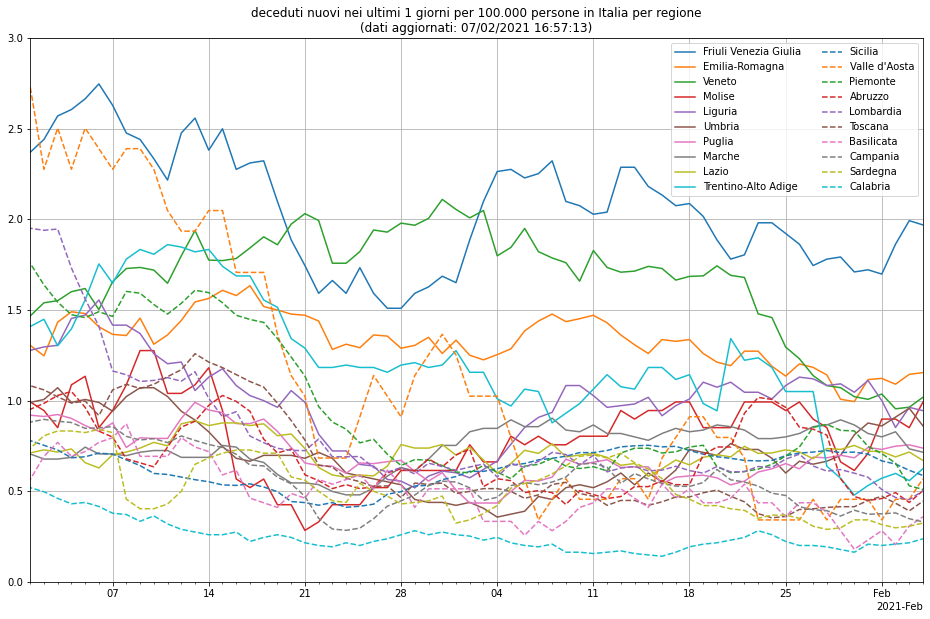

In [23]:
window = 7
case_last_date = (last_date - pd.Timedelta(days=window // 2)).strftime('%Y-%m-%d')
regional.total_cases_figure(column='deceduti', xlim=('2020-12-01', case_last_date), ylim=(0, 3),
                            diff=1, per_population=True, window=window)
plt.show()

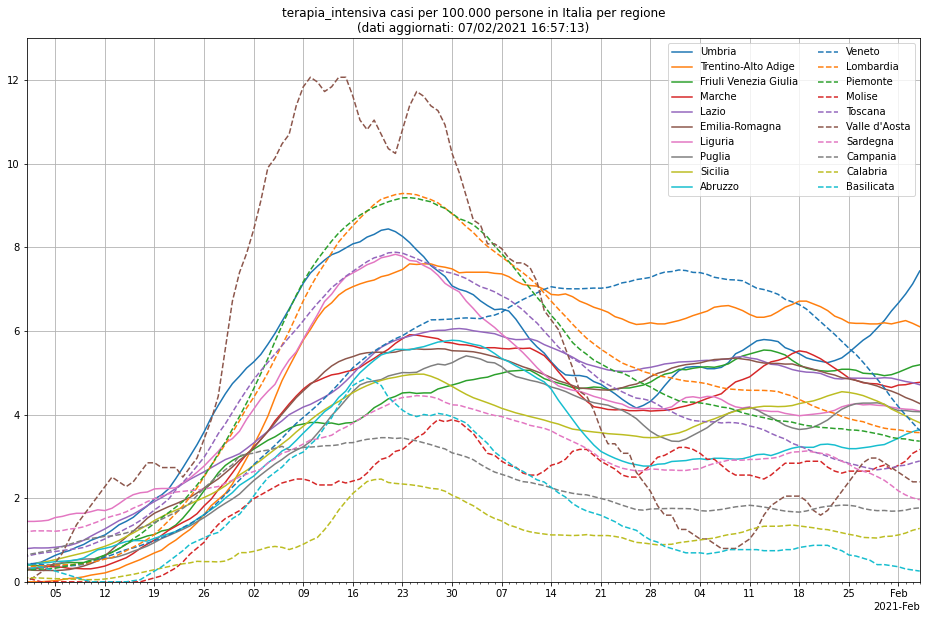

In [24]:
window = 7
last_date = regional.dataset.df.index.max()
case_last_date = (last_date - pd.Timedelta(days=window // 2)).strftime('%Y-%m-%d')
regional.total_cases_figure(per_population=True, column='terapia_intensiva', 
                            diff=False, xlim=('2020-10-01', case_last_date), 
                            ylim=(0, 13), window=window)
plt.show()

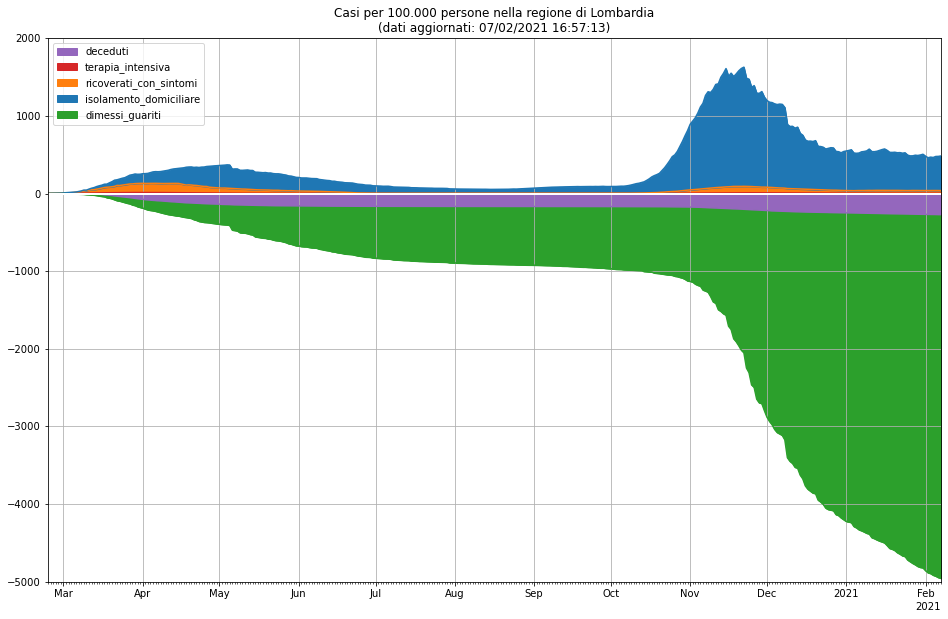

In [163]:
regional.all_regions_cases_figure(show_regions=[
    'Lombardia', 
#     'Piemonte', 'Veneto', 'Sardegna', 'Lazio', 'Liguria', 'Umbria', 
#     'Toscana', 'Emilia-Romagna', 'Puglia', 'Campania', 'Valle d\'Aosta'
], ylim=(-5000, 2000))

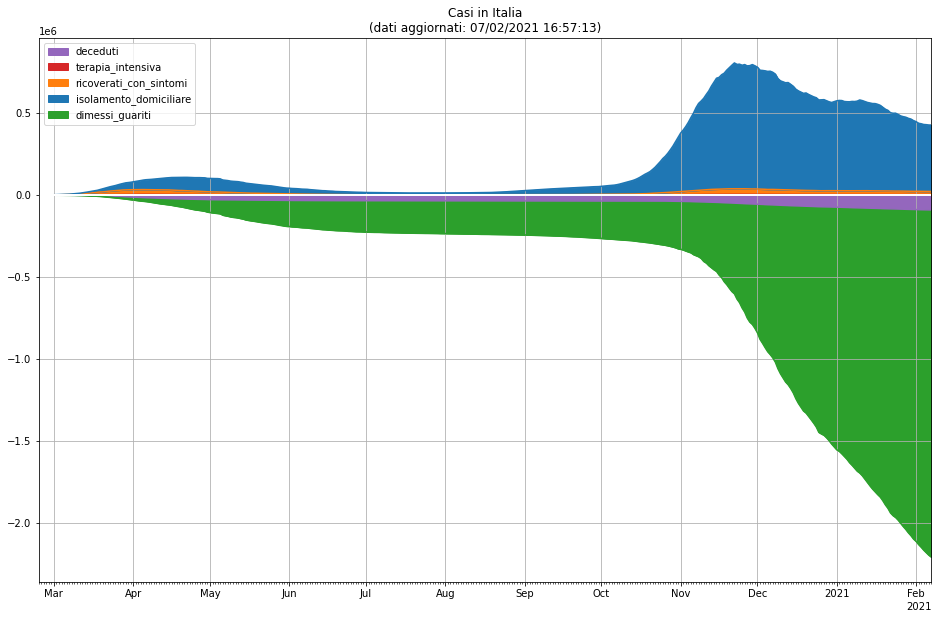

In [26]:
national_tot_df = national.df.copy()
national_tot_df['deceduti'] = -national_tot_df['deceduti']
national_tot_df['dimessi_guariti'] = -national_tot_df['dimessi_guariti']
show_cases(national_tot_df, 1, 
           title=f'Casi in Italia\n(dati aggiornati: {national.last_modified:%d/%m/%Y %H:%M:%S})')
plt.show()

# Lombardia

## Casi totali in Lombardia

In [27]:
mkdir -p figures/overview

In [28]:
from importlib import reload
import ts_viz
reload(ts_viz)
from ts_viz import TimeSeriesViz, OverviewViz

In [29]:
def get_series(region, name):
    region_df = regional_ds.df[regional_ds.df['denominazione_regione'] == region]
    return region_df[name].resample('D').last()

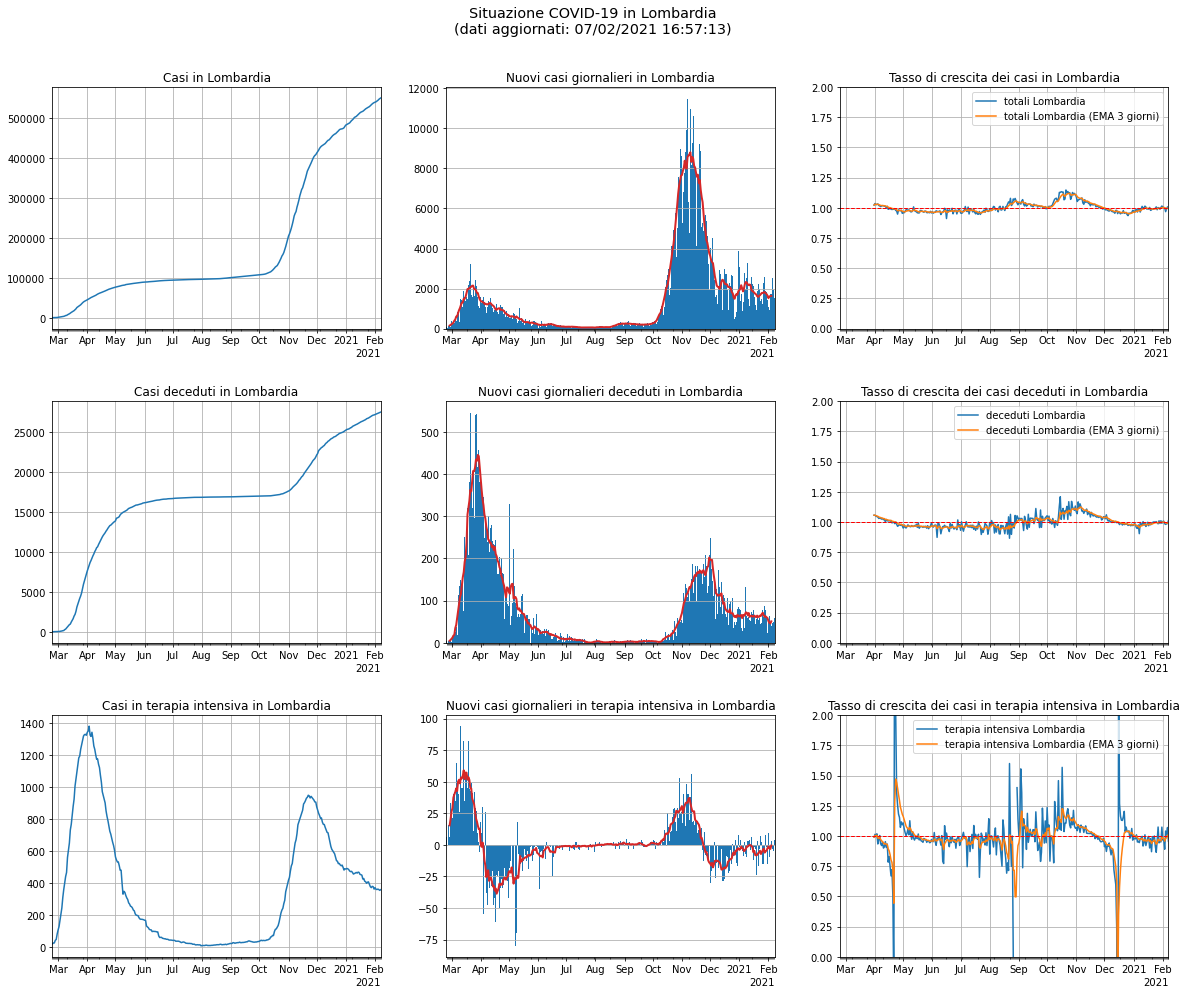

In [30]:
lombardia_df = regional_ds.df[regional_ds.df['denominazione_regione'] == 'Lombardia']
lombardia_overview_viz = OverviewViz('Lombardia', lombardia_df, regional_ds.last_modified, fig_folder='figures/overview')
lombardia_overview_viz.show_overview()

In [31]:
showdiff(lombardia_df['deceduti'], n=10).astype(int)

data
2021-01-29 17:00:00    77
2021-01-30 17:00:00    58
2021-01-31 17:00:00    24
2021-02-01 17:00:00    52
2021-02-02 17:00:00    63
2021-02-03 17:00:00    46
2021-02-04 17:00:00    40
2021-02-05 17:00:00    46
2021-02-06 17:00:00    50
2021-02-07 17:00:00    58
Name: deceduti, dtype: int64

In [32]:
rolldiff = lambda s, w=7: (s - s.shift()).rolling(window=w).mean()
rolldiff(lombardia_df['deceduti']).tail(n=5)

data
2021-02-03 17:00:00    58.285714
2021-02-04 17:00:00    51.428571
2021-02-05 17:00:00    47.000000
2021-02-06 17:00:00    45.857143
2021-02-07 17:00:00    50.714286
Name: deceduti, dtype: float64

In [33]:
showdiff(lombardia_df['totale_casi'], n=20).astype(int)

data
2021-01-19 17:00:00     930
2021-01-20 17:00:00    1876
2021-01-21 17:00:00    2234
2021-01-22 17:00:00    1969
2021-01-23 17:00:00    1535
2021-01-24 17:00:00    1375
2021-01-25 17:00:00    1484
2021-01-26 17:00:00    1230
2021-01-27 17:00:00    2293
2021-01-28 17:00:00    2603
2021-01-29 17:00:00    1900
2021-01-30 17:00:00    1832
2021-01-31 17:00:00    1438
2021-02-01 17:00:00    1093
2021-02-02 17:00:00     912
2021-02-03 17:00:00    1738
2021-02-04 17:00:00    1746
2021-02-05 17:00:00    2504
2021-02-06 17:00:00    1923
2021-02-07 17:00:00    1515
Name: totale_casi, dtype: int64

<AxesSubplot:xlabel='data'>

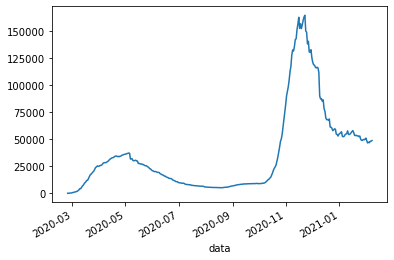

In [34]:
lombardia_df['totale_positivi'].plot()

In [35]:
lombardia_df['terapia_intensiva'].tail(n=10)

data
2021-01-29 17:00:00    379
2021-01-30 17:00:00    377
2021-01-31 17:00:00    362
2021-02-01 17:00:00    371
2021-02-02 17:00:00    361
2021-02-03 17:00:00    359
2021-02-04 17:00:00    362
2021-02-05 17:00:00    359
2021-02-06 17:00:00    354
2021-02-07 17:00:00    358
Name: terapia_intensiva, dtype: int64

In [36]:
showdiff(lombardia_df['terapia_intensiva'], diff=7)

data
2021-01-29 17:00:00   -29.0
2021-01-30 17:00:00   -21.0
2021-01-31 17:00:00   -43.0
2021-02-01 17:00:00   -36.0
2021-02-02 17:00:00   -31.0
2021-02-03 17:00:00   -18.0
2021-02-04 17:00:00    -9.0
2021-02-05 17:00:00   -20.0
2021-02-06 17:00:00   -23.0
2021-02-07 17:00:00    -4.0
Name: terapia_intensiva, dtype: float64

In [37]:
lomb_casi_diff = lombardia_df['casi_testati'] - lombardia_df['casi_testati'].shift()
lomb_tamp_diff = lombardia_df['tamponi'] - lombardia_df['tamponi'].shift()
(lomb_tamp_diff / lomb_casi_diff).tail(n=10)

data
2021-01-29 17:00:00    3.904435
2021-01-30 17:00:00    4.275406
2021-01-31 17:00:00    3.326181
2021-02-01 17:00:00    3.001575
2021-02-02 17:00:00    5.030807
2021-02-03 17:00:00    4.005700
2021-02-04 17:00:00    3.720671
2021-02-05 17:00:00    3.448236
2021-02-06 17:00:00    4.116802
2021-02-07 17:00:00    3.212467
dtype: float64

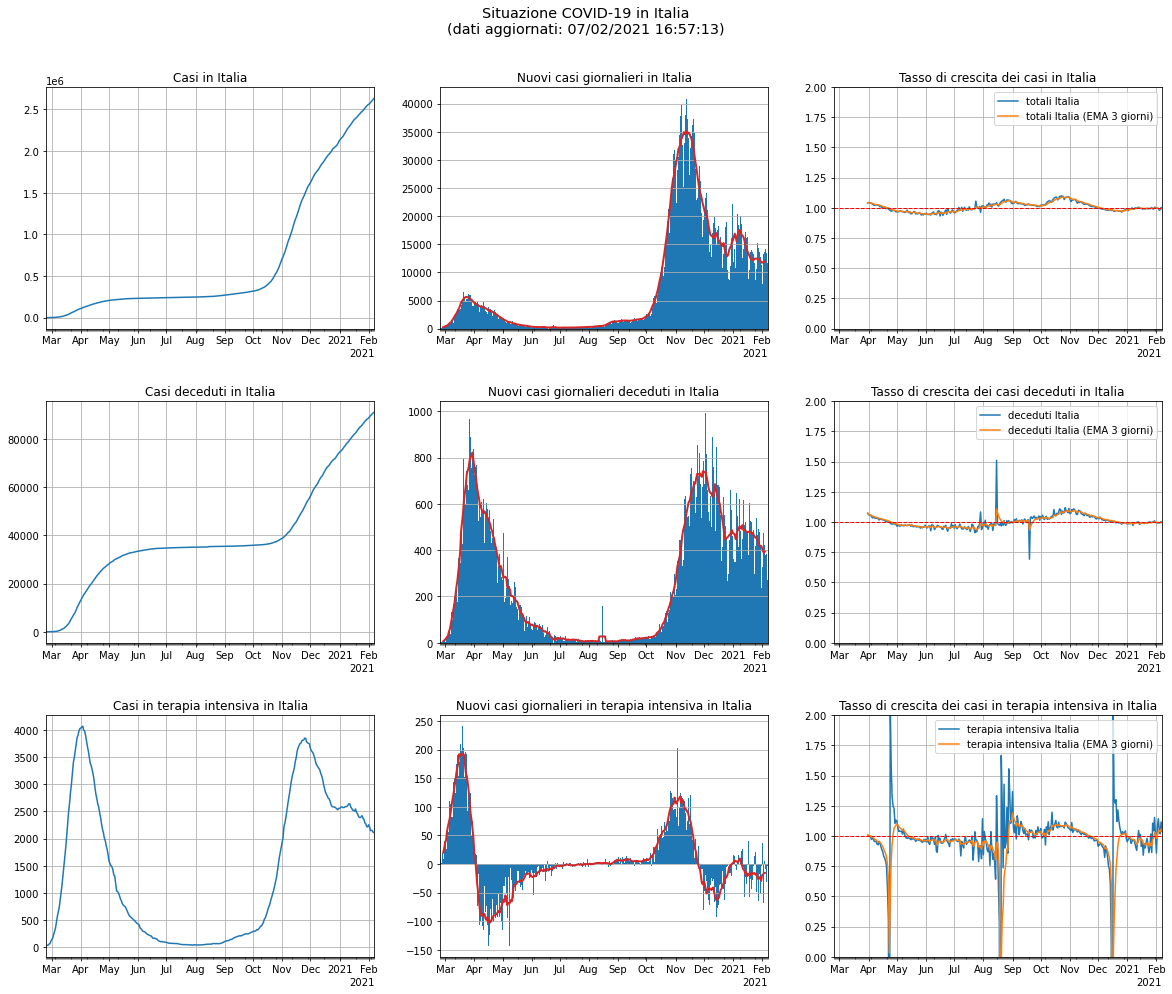

In [38]:
italia_df = national.df
italia_overview_viz = OverviewViz('Italia', national.df, national.last_modified, fig_folder='figures/overview')
italia_overview_viz.show_overview()

In [39]:
showdiff(italia_df['totale_casi'])

data
2021-01-29    13563.0
2021-01-30    12713.0
2021-01-31    11249.0
2021-02-01     7925.0
2021-02-02     9651.0
2021-02-03    13182.0
2021-02-04    13656.0
2021-02-05    14213.0
2021-02-06    13439.0
2021-02-07    11640.0
Freq: D, Name: totale_casi, dtype: float64

In [40]:
showdiff(italia_df['deceduti'])

data
2021-01-29    477.0
2021-01-30    421.0
2021-01-31    237.0
2021-02-01    329.0
2021-02-02    498.0
2021-02-03    476.0
2021-02-04    422.0
2021-02-05    377.0
2021-02-06    385.0
2021-02-07    270.0
Freq: D, Name: deceduti, dtype: float64

In [41]:
rolldiff(italia_df['deceduti']).tail()

data
2021-02-03    418.571429
2021-02-04    408.571429
2021-02-05    394.285714
2021-02-06    389.142857
2021-02-07    393.857143
Freq: D, Name: deceduti, dtype: float64

In [42]:
italia_df['terapia_intensiva'].tail(n=10)

data
2021-01-29    2270
2021-01-30    2218
2021-01-31    2215
2021-02-01    2252
2021-02-02    2214
2021-02-03    2145
2021-02-04    2151
2021-02-05    2142
2021-02-06    2110
2021-02-07    2107
Freq: D, Name: terapia_intensiva, dtype: int64

In [43]:
lombardia_active = get_series('Lombardia', 'totale_positivi')
lombardia_active[-1] / lombardia_active[-14]

0.9772495347860015

In [44]:
lombardia_totale = get_series('Lombardia', 'totale_casi')
lombardia_totale.name = 'totali Lombardia'
lombardia_totale_viz = TimeSeriesViz(series=lombardia_totale, last_modified=regional_ds.last_modified)
lombardia_totale_viz.logger.setLevel(logging.INFO)
lombardia_tamp = get_series('Lombardia', 'casi_testati')
# lombardia_tamp = get_series('Lombardia', 'tamponi')

In [45]:
lombardia_totale.tail()

data
2021-02-03    541797
2021-02-04    543543
2021-02-05    546047
2021-02-06    547970
2021-02-07    549485
Freq: D, Name: totali Lombardia, dtype: int64

In [46]:
lombardia_tamp.tail().astype(int)

data
2021-02-03    2856882
2021-02-04    2865764
2021-02-05    2877075
2021-02-06    2885842
2021-02-07    2894441
Freq: D, Name: casi_testati, dtype: int64

In [47]:
showdiff(lombardia_tamp)

data
2021-01-29     8748.0
2021-01-30     9230.0
2021-01-31     7364.0
2021-02-01     5714.0
2021-02-02     4512.0
2021-02-03     9649.0
2021-02-04     8882.0
2021-02-05    11311.0
2021-02-06     8767.0
2021-02-07     8599.0
Freq: D, Name: casi_testati, dtype: float64

In [48]:
lomb_tot_new = lombardia_totale - lombardia_totale.shift()
lomb_tamp_new = lombardia_tamp - lombardia_tamp.shift()
lomb_tamp_rate = lomb_tot_new / lomb_tamp_new

In [49]:
# tamp_selector = 'casi_testati'
tamp_selector = 'tamponi'

def tamp_rate(region, window=1, extend=False, ylim=(0, 100)):
    tamp = get_series(region, tamp_selector)
    tot = get_series(region, 'totale_casi')

    tot_new = rolling_mean(tot - tot.shift(), window, extend=extend)
    tamp_new = rolling_mean(tamp - tamp.shift(), window, extend=extend)
    tamp_rate = tot_new / tamp_new * 100
    
    fig, ax = plt.subplots(figsize=(16, 10))
    tamp_rate.plot()
    ax.set_ylim(ylim)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    
    ax.yaxis.grid(True, which='major')
    ax.set_title(f'Percentuale positivi dei {tamp_selector} in {region}')
    ax.set_xlim(('2020-09-01', None))
    plt.show()
    print(tamp_rate.tail(n=10))

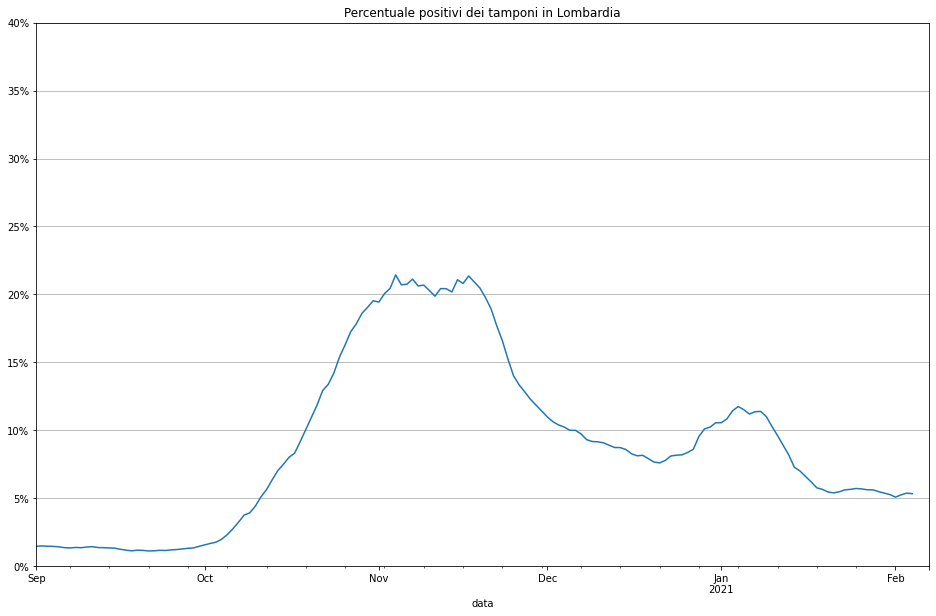

data
2021-01-29    5.486981
2021-01-30    5.378083
2021-01-31    5.275551
2021-02-01    5.083945
2021-02-02    5.250645
2021-02-03    5.377551
2021-02-04    5.334933
2021-02-05         NaN
2021-02-06         NaN
2021-02-07         NaN
Freq: D, dtype: float64


In [50]:
tamp_rate('Lombardia', ylim=(0, 40), window=7)

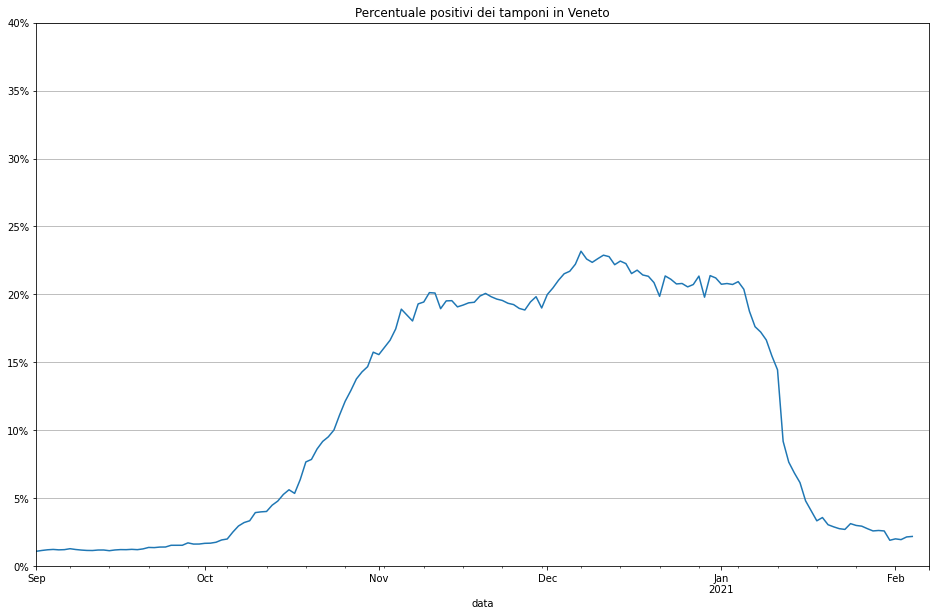

data
2021-01-29    2.628115
2021-01-30    2.593803
2021-01-31    1.907711
2021-02-01    2.011600
2021-02-02    1.955707
2021-02-03    2.153782
2021-02-04    2.189056
2021-02-05         NaN
2021-02-06         NaN
2021-02-07         NaN
Freq: D, dtype: float64


In [51]:
tamp_rate('Veneto', window=7, ylim=(0, 40))

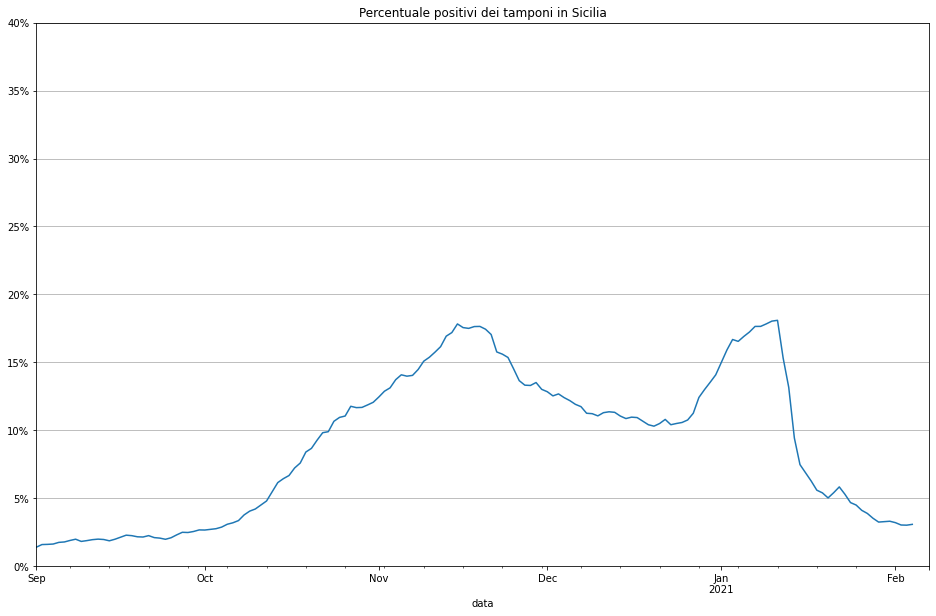

data
2021-01-29    3.247169
2021-01-30    3.277072
2021-01-31    3.308584
2021-02-01    3.204681
2021-02-02    3.031631
2021-02-03    3.018723
2021-02-04    3.078617
2021-02-05         NaN
2021-02-06         NaN
2021-02-07         NaN
Freq: D, dtype: float64


In [52]:
tamp_rate('Sicilia', window=7, ylim=(0, 40))

In [53]:
# tamp_rate('Lazio')

In [54]:
# tamp_rate('Campania')

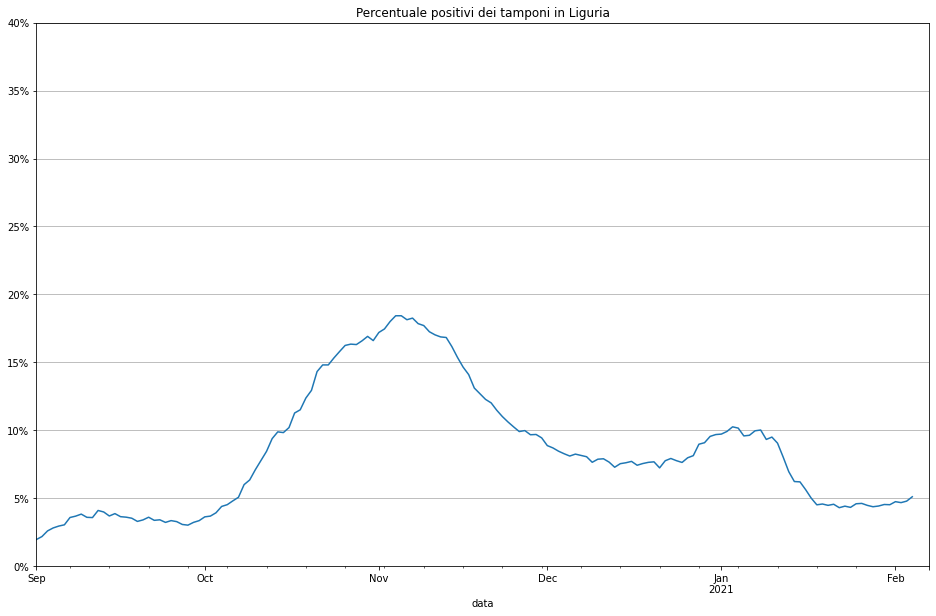

data
2021-01-29    4.427477
2021-01-30    4.540421
2021-01-31    4.523827
2021-02-01    4.748062
2021-02-02    4.678267
2021-02-03    4.788832
2021-02-04    5.109131
2021-02-05         NaN
2021-02-06         NaN
2021-02-07         NaN
Freq: D, dtype: float64


In [55]:
tamp_rate('Liguria', window=7, ylim=(0, 40))

In [56]:
# tamp_rate('Umbria', ylim=(0, 100))

In [57]:
# tamp_rate('Toscana')

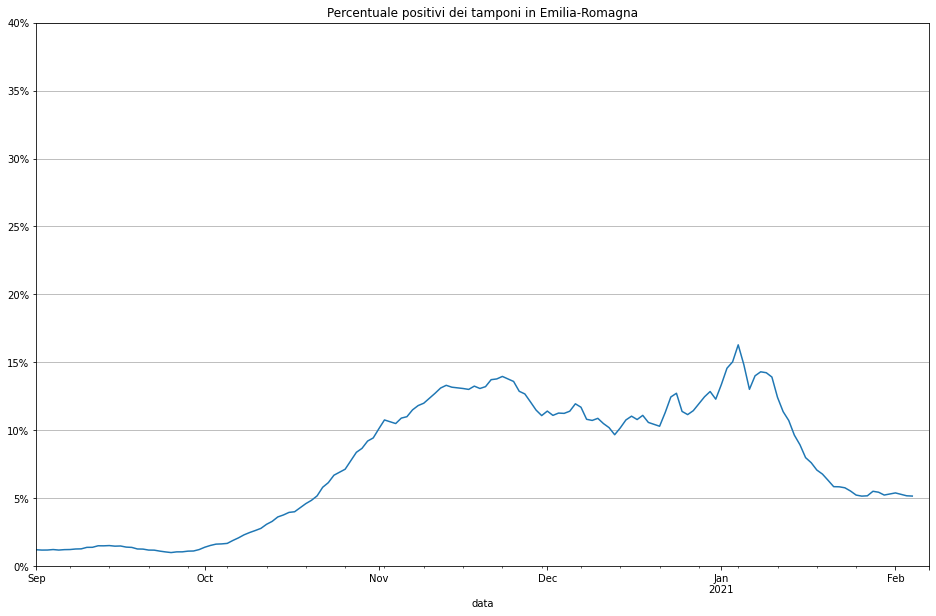

data
2021-01-29    5.442982
2021-01-30    5.234933
2021-01-31    5.317587
2021-02-01    5.392226
2021-02-02    5.283725
2021-02-03    5.180834
2021-02-04    5.160457
2021-02-05         NaN
2021-02-06         NaN
2021-02-07         NaN
Freq: D, dtype: float64


In [58]:
tamp_rate('Emilia-Romagna', window=7, ylim=(0, 40))

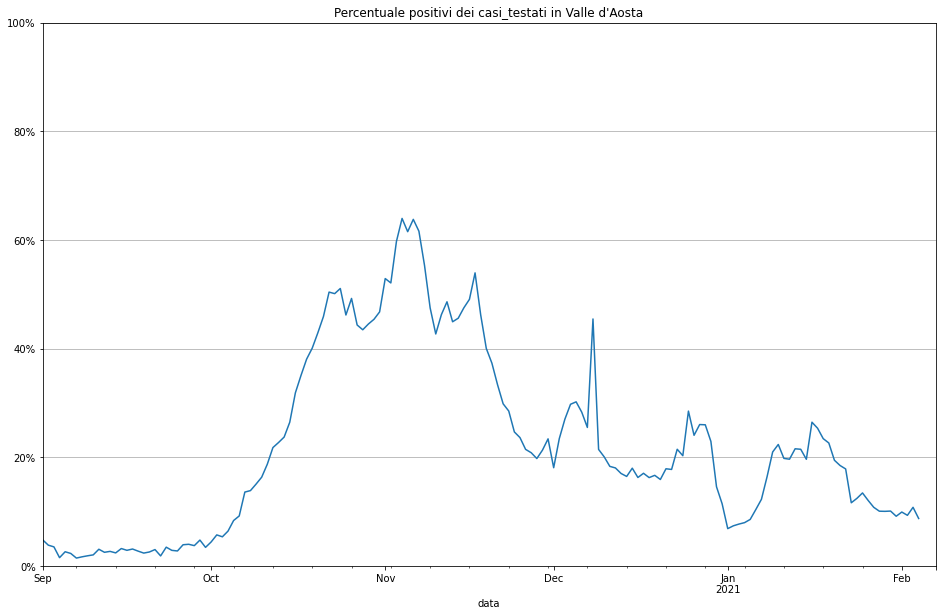

data
2021-01-29    10.091743
2021-01-30    10.142349
2021-01-31     9.189189
2021-02-01     9.963100
2021-02-02     9.358752
2021-02-03    10.834813
2021-02-04     8.778626
2021-02-05          NaN
2021-02-06          NaN
2021-02-07          NaN
Freq: D, dtype: float64


In [164]:
tamp_rate('Valle d\'Aosta', window=7)

In [60]:
# tamp_rate('Calabria', ylim=(0, 80))

In [61]:
# lombardia_totale_viz.show_series(title='Casi totali in Lombardia', save_fig=True, save_csv=True)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi giornalieri in Lombardia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

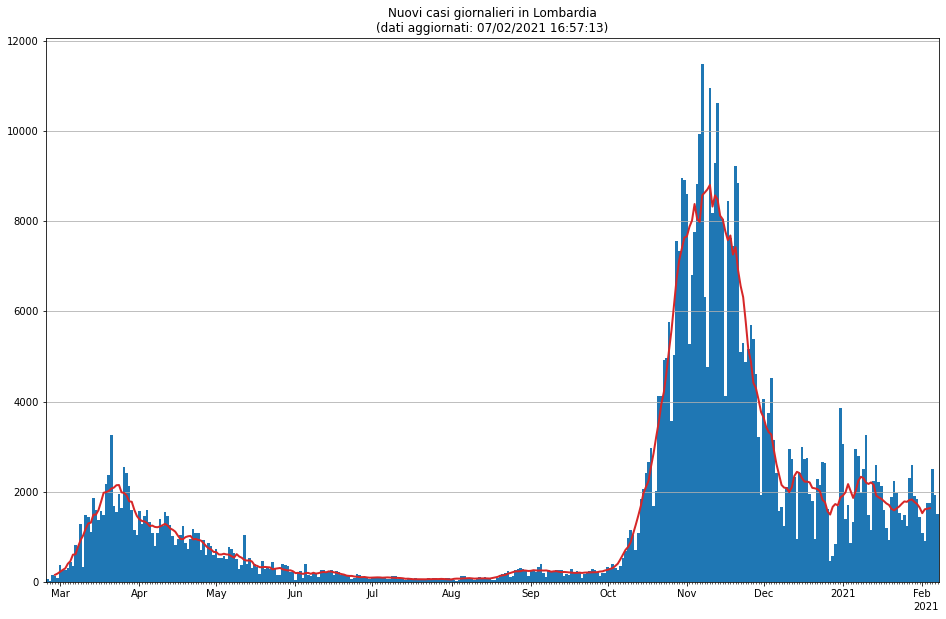

In [62]:
lombardia_totale_viz.show_new(title='Nuovi casi giornalieri in Lombardia')

In [63]:
(lombardia_totale_viz.series - lombardia_totale_viz.series.shift()).tail()

data
2021-02-03    1738.0
2021-02-04    1746.0
2021-02-05    2504.0
2021-02-06    1923.0
2021-02-07    1515.0
Freq: D, Name: totali Lombardia, dtype: float64

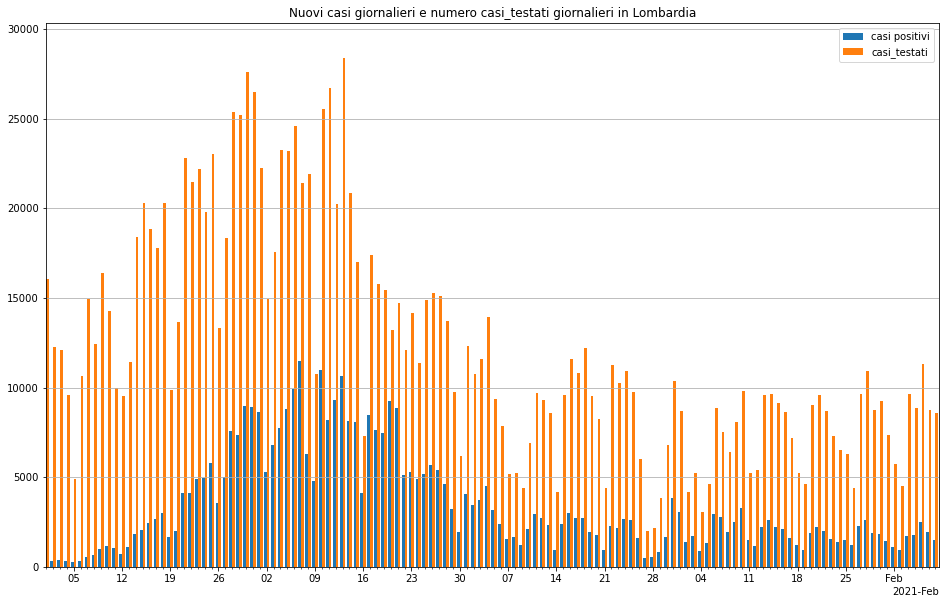

In [64]:
from matplotlib.dates import date2num, datestr2num
fig, ax = plt.subplots(figsize=(16, 10))
lombardia_totale = get_series('Lombardia', 'totale_casi')
tamp_selector = 'casi_testati'
# tamp_selector = 'tamponi'
lombardia_tamp = get_series('Lombardia', tamp_selector)

diff_tot = (lombardia_totale - lombardia_totale.shift())
diff_tamp = (lombardia_tamp - lombardia_tamp.shift())
ax.bar(date2num(diff_tot.index) - 0.2, diff_tot, width=0.4, label='casi positivi')
ax.bar(date2num(diff_tamp.index) + 0.2, diff_tamp, width=0.4, label=tamp_selector)
ax.set_title(f'Nuovi casi giornalieri e numero {tamp_selector} giornalieri in Lombardia')
ax.yaxis.grid(True, which='major')
locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.set_ylim(0, None)
ax.legend()
ax.set_xlim((datestr2num('2020-10-01'), date2num(diff_tot.index + pd.Timedelta(days=0.5)).max()))
plt.show()

In [65]:
showdiff(lombardia_tamp)

data
2021-01-29     8748.0
2021-01-30     9230.0
2021-01-31     7364.0
2021-02-01     5714.0
2021-02-02     4512.0
2021-02-03     9649.0
2021-02-04     8882.0
2021-02-05    11311.0
2021-02-06     8767.0
2021-02-07     8599.0
Freq: D, Name: casi_testati, dtype: float64

In [66]:
data = {
    'diff_tamp': diff_tamp,
    'diff_tot': diff_tot,
    'tamp_for_last': diff_tamp / diff_tamp[-1],
    'norm_tamp': (diff_tot / (diff_tamp / diff_tamp[-1])),
    'tamp_rate': diff_tamp / diff_tot,
    'pos_rate': (diff_tot / diff_tamp).apply('{:.0%}'.format)
}
pd.DataFrame(data).tail(n=10)

diff_tamp  diff_tot  tamp_for_last    norm_tamp  tamp_rate  \
data                                                                     
2021-01-29     8748.0    1900.0       1.017328  1867.638317   4.604211   
2021-01-30     9230.0    1832.0       1.073381  1706.757096   5.038210   
2021-01-31     7364.0    1438.0       0.856379  1679.163770   5.121001   
2021-02-01     5714.0    1093.0       0.664496  1644.855968   5.227813   
2021-02-02     4512.0     912.0       0.524712  1738.095745   4.947368   
2021-02-03     9649.0    1738.0       1.122107  1548.871593   5.551784   
2021-02-04     8882.0    1746.0       1.032911  1690.368611   5.087056   
2021-02-05    11311.0    2504.0       1.315386  1903.624436   4.517173   
2021-02-06     8767.0    1923.0       1.019537  1886.149994   4.559022   
2021-02-07     8599.0    1515.0       1.000000  1515.000000   5.675908   

           pos_rate  
data                 
2021-01-29      22%  
2021-01-30      20%  
2021-01-31      20%  
2021-02-01      19%  
2021-02-02      20%  
2021-02-03      18%  
2021-02-04      20%  
2021-02-05      22%  
2021-02-06      22%  
2021-02-07      18%

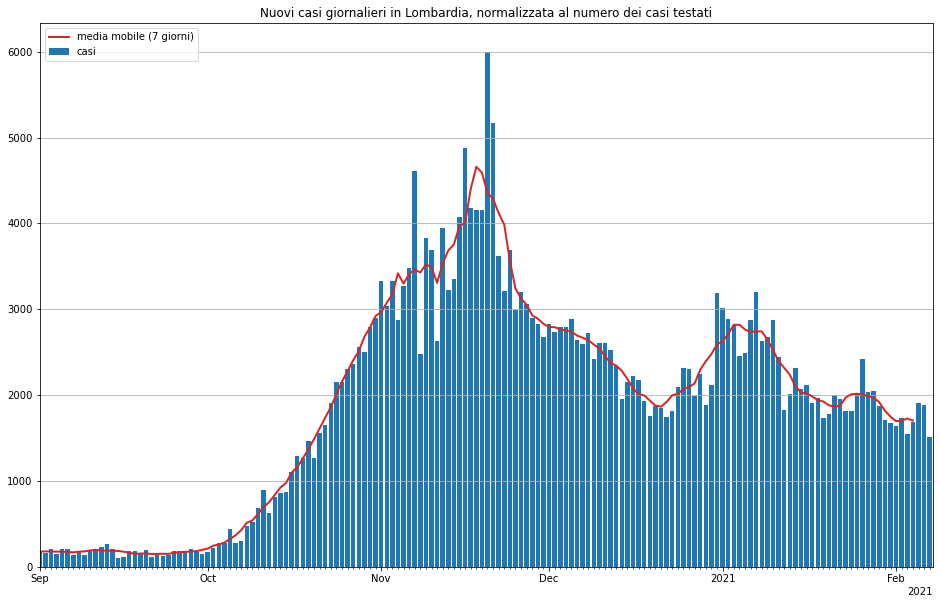

In [67]:
title = f'Nuovi casi giornalieri in Lombardia, normalizzata al numero dei {tamp_selector.replace("_", " ")}'
sma = 7
fig, ax = TimeSeriesViz.config_axis(figsize=(16, 10), xgrid=False, title=title)
norm_tamp = diff_tot / (diff_tamp / diff_tamp[-1])
ax.bar(norm_tamp.index, norm_tamp, label='casi')

norm_tamp_sma = norm_tamp.rolling(sma, center=True).mean()
ax.plot(norm_tamp_sma.index, norm_tamp_sma, color='tab:red', lw=2, label=f'media mobile ({sma} giorni)')

valid_index = norm_tamp[~norm_tamp.isna()].index
ax.set_xlim((valid_index.min() + pd.Timedelta(days=.5), valid_index.max() + pd.Timedelta(days=.5)))
# ax.get_yaxis().set_visible(False)
ax.set_ylim((0, None))
ax.set_xlim(('2020-09-01', None))
locator = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.legend(loc='upper left')
plt.show()

In [68]:
diff_tot.tail(n=10)

data
2021-01-29    1900.0
2021-01-30    1832.0
2021-01-31    1438.0
2021-02-01    1093.0
2021-02-02     912.0
2021-02-03    1738.0
2021-02-04    1746.0
2021-02-05    2504.0
2021-02-06    1923.0
2021-02-07    1515.0
Freq: D, Name: totale_casi, dtype: float64

In [69]:
# fig, ax = plt.subplots(figsize=(16, 10))
# norm_sum = norm_tamp.expanding().sum()
# ax = norm_sum.plot()
# ax.set_xlim(('2020-04-15', None))
# plt.show()

In [70]:
# lombardia_totale_viz.show_growth_factor(title='Tasso di crescita per i casi totali in Lombardia', 
#                                         raw=True, sma=False, ema=True, save_fig=True, save_csv=True, window=7, ylim=(0, 3))

## Casi decessi in Lombardia

In [71]:
lombardia_deaths = regional_ds.df[regional_ds.df['denominazione_regione'] == 'Lombardia']['deceduti'].resample('D').last()
lombardia_deaths.name = 'deceduti Lombardia'
lombardia_deaths_viz = TimeSeriesViz(series=lombardia_deaths, last_modified=regional_ds.last_modified)
lombardia_deaths_viz.logger.setLevel(logging.INFO)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Casi deceduti in Lombardia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

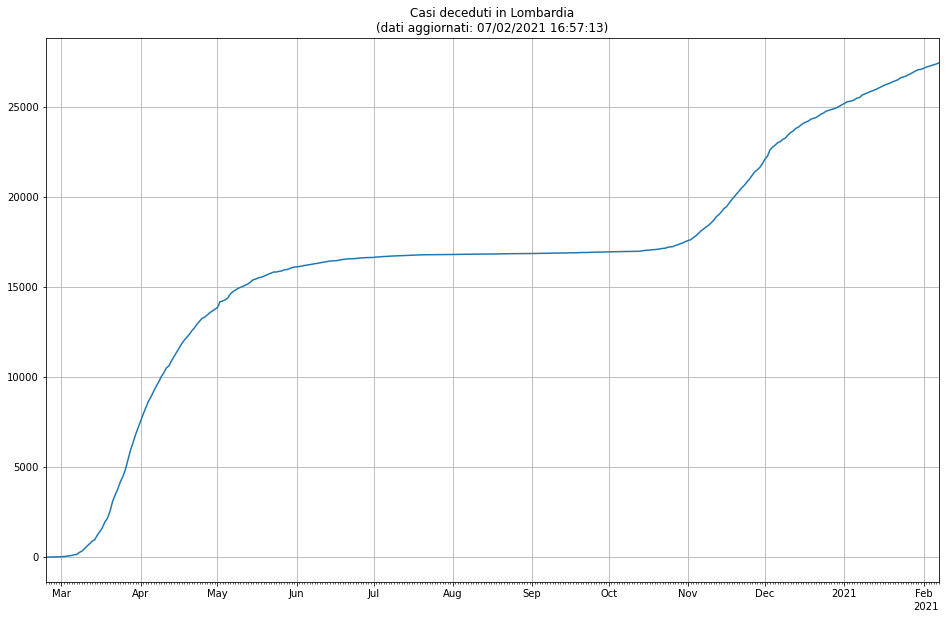

In [72]:
lombardia_deaths_viz.show_series(title='Casi deceduti in Lombardia')

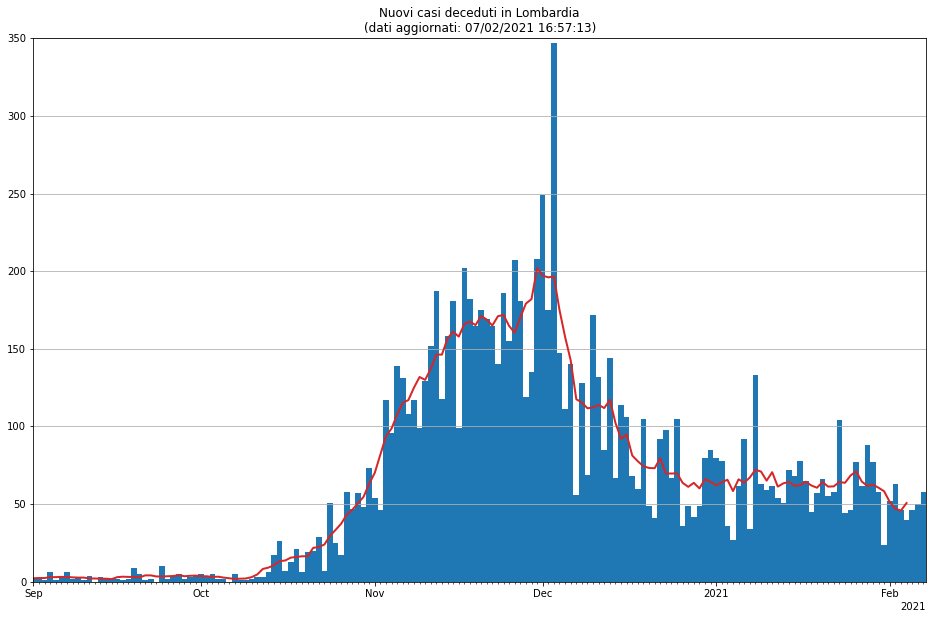

In [73]:
fig, ax = lombardia_deaths_viz.show_new(title='Nuovi casi deceduti in Lombardia')
ax.set_xlim(('2020-09-01', None))
ax.set_ylim((0, 350))
plt.show()

In [74]:
# lomb_death = lombardia_deaths_viz.series - lombardia_deaths_viz.series.shift()
# lomb_death[lomb_death >= lomb_death[-1]].tail(n=10)

In [75]:
showdiff(lombardia_deaths_viz.series, n=10).astype(int)

data
2021-01-29    77
2021-01-30    58
2021-01-31    24
2021-02-01    52
2021-02-02    63
2021-02-03    46
2021-02-04    40
2021-02-05    46
2021-02-06    50
2021-02-07    58
Freq: D, Name: deceduti Lombardia, dtype: int64

In [76]:
lombardia_ti = get_series('Lombardia', 'terapia_intensiva')

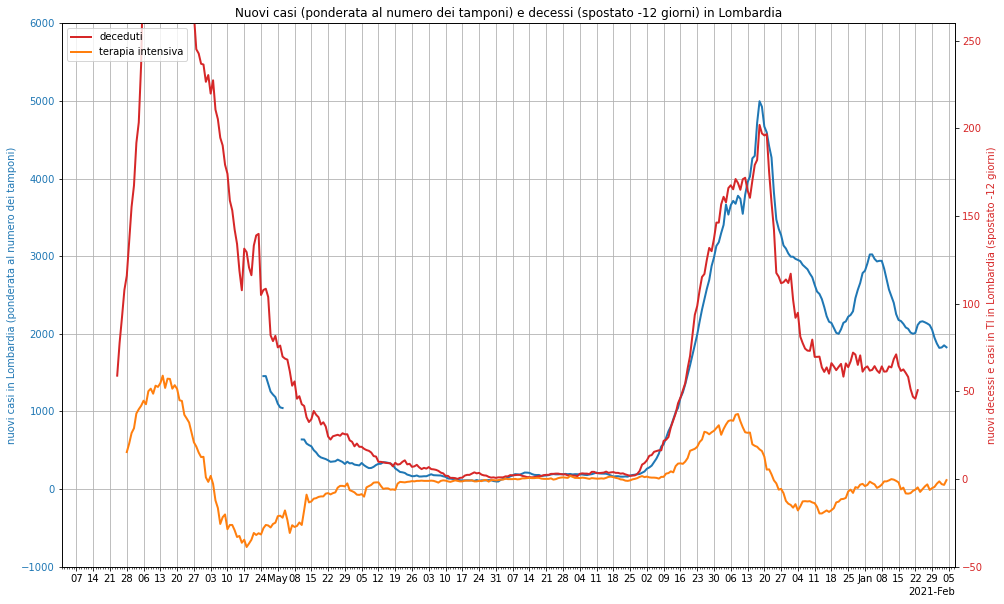

In [77]:
window = 7
fig, ax = TimeSeriesViz.config_axis(figsize=(16, 10), xgrid=False, title=title)
norm_tamp = (diff_tot / (diff_tamp / diff_tamp.mean()))['2020-02-01':]
norm_tamp = rolling_mean(norm_tamp, window, extend=False)
color = 'tab:blue'
ax.plot(norm_tamp.index, norm_tamp, color=color, label='nuovi casi giornalieri, ponderata ai tamponi', lw=2)
ax.set_xlim((norm_tamp.index.min() + pd.Timedelta(days=.5), norm_tamp.index.max() + pd.Timedelta(days=.5)))
ax.set_ylabel('nuovi casi in Lombardia (ponderata al numero dei tamponi)', color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim((0, None))
lombardia_deaths_diff = lombardia_deaths - lombardia_deaths.shift()
lombardia_deaths_diff = rolling_mean(lombardia_deaths_diff, window, extend=False)
ltid = lombardia_ti - lombardia_ti.shift()
ltid = rolling_mean(ltid, window, extend=False)
ltids = ltid.shift(-0)
sh = -12
ldds = lombardia_deaths_diff.shift(sh)
ax2 = ax.twinx()
color = 'tab:red'
ax2.plot(ldds.index, ldds, color=color, label='deceduti', lw=2)
ax2.plot(ltids.index, ltids, color='tab:orange', label='terapia intensiva', lw=2)
ax2.set_ylabel(f'nuovi decessi e casi in TI in Lombardia (spostato {sh} giorni)', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim((0, None))
ax.set_title(f'Nuovi casi (ponderata al numero dei tamponi) e decessi (spostato {sh} giorni) in Lombardia')
locator = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
ax.xaxis.grid(True, which='major')
ax.set_xlim(('2020-02-01', None))
ax.set_ylim(-1000, 6000)
ax2.set_ylim(-50, 260)
plt.legend(loc='upper left')
plt.show()

In [78]:
showdiff(national.df['deceduti'])

data
2021-01-29    477.0
2021-01-30    421.0
2021-01-31    237.0
2021-02-01    329.0
2021-02-02    498.0
2021-02-03    476.0
2021-02-04    422.0
2021-02-05    377.0
2021-02-06    385.0
2021-02-07    270.0
Freq: D, Name: deceduti, dtype: float64

In [79]:
get_series('Lombardia', 'totale_casi').tail()

data
2021-02-03    541797
2021-02-04    543543
2021-02-05    546047
2021-02-06    547970
2021-02-07    549485
Freq: D, Name: totale_casi, dtype: int64

In [80]:
get_series('Lombardia', 'deceduti').tail()

data
2021-02-03    27259
2021-02-04    27299
2021-02-05    27345
2021-02-06    27395
2021-02-07    27453
Freq: D, Name: deceduti, dtype: int64

In [81]:
coefs = {}

In [82]:
import warnings

# region = 'Lombardia'
# lombardia_deaths = get_series(region, 'deceduti')

# observed = (lombardia_deaths - lombardia_deaths.shift())[1:]

# popt, pcov, fit = show_fit(observed, func, func_name, figsize=(16, 10), pred=30, 
#                            title=f'Nuovi deceduti giornalieri in {region} + {func_name} '
#                                  f'fit\n$n(t)=Kt^{{x}}e^{{-t/t_0}}$')
# # popt, pcov, ymax = fit_curve(observed, func, func_name, pred=7)
# K, x, t0 = popt
# coefs['Lombardia deceduti'] = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {observed.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {fit.index[np.argmax(fit)]:%Y-%m-%d}')

In [83]:
from scipy.optimize import curve_fit
from matplotlib import cm
import numpy as np

func = lambda t, K, x, t0, b: K * np.power(t, x) * np.exp(-t / t0) + b
func_name = 'power'

# func = lambda x, a, b: a * np.exp(b * x) 

def fit_curves(series, func, name, lookback=8, cmap='Reds'):
    colormap = cm.get_cmap(cmap)

    for i in range(0, lookback + 1):
        to_fit = series[:-i] if i > 0 else series
        x = np.arange(len(to_fit))
        popt, pcov = curve_fit(func, x, to_fit.values)
        plt.plot(series.index, func(np.arange(len(series)), *popt), 
                 label=f'{name} fit -{i} days', c=colormap(i/lookback))

# fig, ax = plt.subplots(figsize=(10, 6))

# fit_curves(lombardia_deaths, func, func_name, lookback=12, cmap='winter')
# # plt.plot(lombardia_deaths.index, lombardia_deaths.values)
# ax = lombardia_deaths.plot(c='r', lw=3)
# ax.set_title(f'Decessi in Lombardia + {func_name} fit')
# plt.legend()

In [84]:
# lomb_diff = (lombardia_totale - lombardia_totale.shift())[1:]
# fig, ax = plt.subplots(figsize=(10, 6))
# fit_curves(lomb_diff, func, func_name, cmap='winter')
# plt.bar(lombardia_totale.index, lombardia_totale.values)
# ax.set_title('Casi totali in Lombardia + exp fit')
# plt.legend()

Fit error: 335.56
Predicted volume error: 0.00%
Lombardia: K = 0.00011348, x = 6.05, t0 = 8.44, b = 361.95
first day: 2020-09-20
peak as of fit: 2020-11-10


array([1.13480303e-04, 6.04621305e+00, 8.43911885e+00, 3.61948317e+02])

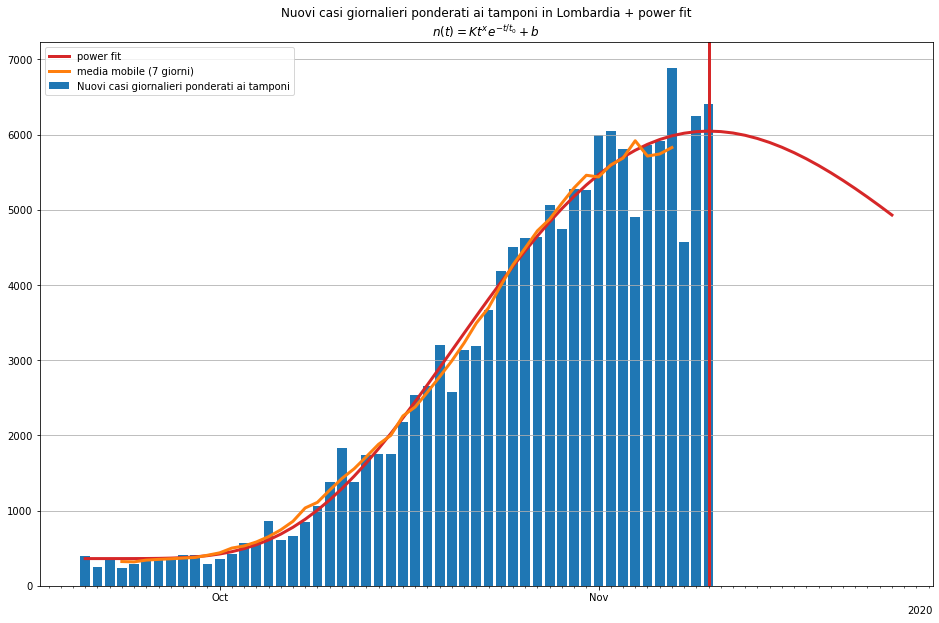

In [85]:
def get_normalized_new(region, start_day=None):
    total = get_series(region, 'totale_casi')
#    tests = get_series(region, 'casi_testati')
    tests = get_series(region, 'tamponi')
    diff_total = (total - total.shift())
    diff_tests = (tests - tests.shift())
    normalized_new = (diff_total / (diff_tests / diff_tests[-1]))[1:]
    if start_day:
        normalized_new = normalized_new[start_day:]
    normalized_new.name = f'Nuovi casi giornalieri ponderati ai {tests.name.replace("_", " ")}'
    return normalized_new

region = 'Lombardia'
normalized_new = get_normalized_new(region, start_day='2020-09-20')
normalized_new = normalized_new[:'2020-11-10']
# normalized_new -= 500
# normalized_new['2020-02-27'] = (normalized_new['2020-02-25'] + normalized_new['2020-02-28']) / 2
# normalized_new['2020-02-26'] = (normalized_new['2020-02-25'] + normalized_new['2020-02-27']) / 2
# normalized_new['2020-03-05'] = (normalized_new['2020-03-04'] + normalized_new['2020-03-06']) / 2
# normalized_new['2020-03-09'] = (normalized_new['2020-03-08'] + normalized_new['2020-03-10']) / 2
popt, pcov, fit, argmax = show_fit(normalized_new, func, func_name, pred=15, figsize=(16, 10),
                                   title=f'{normalized_new.name} in {region} + {func_name} fit\n'
                                         f'$n(t)=Kt^{{x}}e^{{-t/t_0}}+b$', 
                                   window=7, ma_color='tab:orange')
K, x, t0, b = popt
coefs['Lombardia casi_norm'] = popt
print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}, b = {b:.02f}')
print(f'first day: {normalized_new.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')
popt

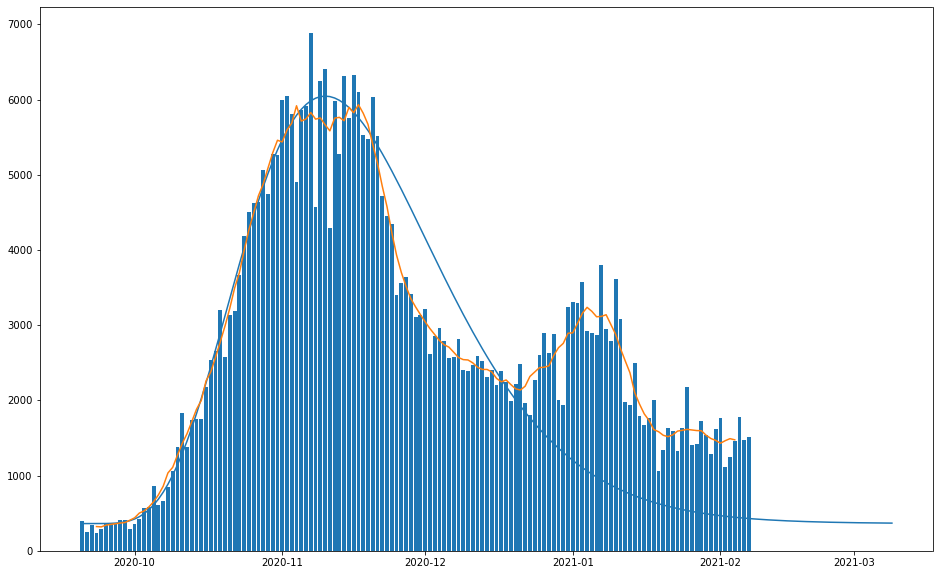

In [86]:
series = get_normalized_new(region, start_day='2020-09-20')
index = pd.date_range(series.index.min(), periods=(len(series) + 30), freq='D')
y = func(np.arange(len(index)), *popt)
fit = pd.Series(y, index=index)
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(fit.index, fit)
ax.bar(series.index, series)
ax.plot(series.index, series.rolling(7, center=True).mean())

Text(0.5, 1.0, 'Percentuale dei nuovi casi testati tra i tamponi in Lombardia')

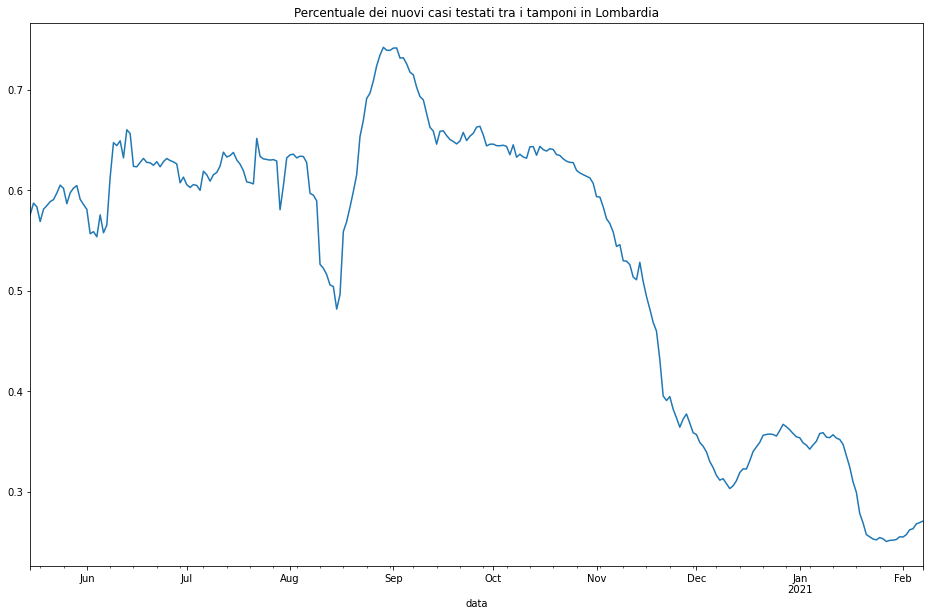

In [87]:
tests = get_series(region, 'casi_testati')
tests_diff = tests - tests.shift()
tamp = get_series(region, 'tamponi')
tamp_diff = tamp - tamp.shift()
(tests_diff/tamp_diff).rolling(window=7).mean()['2020-05-15':].plot(figsize=(16, 10))
plt.title(f'Percentuale dei nuovi casi testati tra i tamponi in {region}')

In [88]:
region = 'Veneto'
# veneto_deaths = get_series(region, 'deceduti')

# fig, ax = plt.subplots(figsize=(16, 10))
# observed = (veneto_deaths - veneto_deaths.shift())[4:]
# popt, pcov, y = show_fit(observed, func, func_name, title=f'Nuovi deceduti giornalieri in {region} + {func_name} fit', ax=ax)
# ax.set_ylim((0, 50))
# K, x, t0 = popt
# coefs['Veneto deceduti'] = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {observed.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {observed.index[np.argmax(y)]:%Y-%m-%d}')

Fit error: 703.95
Predicted volume error: 0.00%
Veneto: K = 0.00000000, x = 7.93, t0 = 11.26, b = 109.07
first day: 2020-09-01
peak as of fit: 2020-11-29


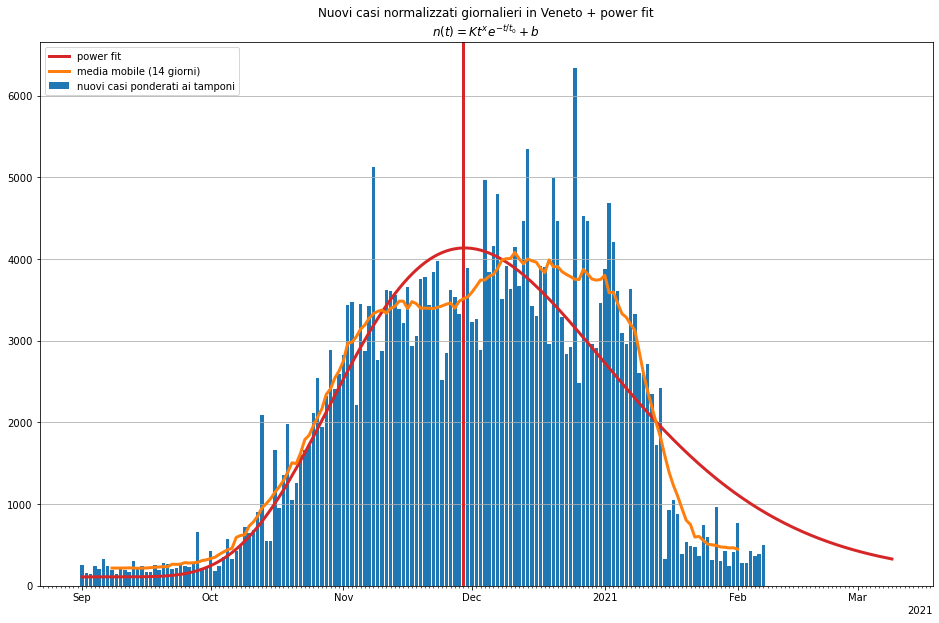

In [89]:
region = 'Veneto'
normalized_new = get_normalized_new(region, start_day='2020-09-01')
# normalized_new['2020-03-09'] = (normalized_new['2020-03-08'] + normalized_new['2020-03-10']) / 2
# normalized_new['2020-03-17'] = (normalized_new['2020-03-16'] + normalized_new['2020-03-18']) / 2
fig, ax = plt.subplots(figsize=(16, 10))
normalized_new.name = 'nuovi casi ponderati ai tamponi'
popt, pcov, fit, argmax = show_fit(normalized_new, func, func_name, ax=ax, pred=30,
                                   title=f'Nuovi casi normalizzati giornalieri in {region} + {func_name} '
                                         f'fit\n$n(t)=Kt^{{x}}e^{{-t/t_0}}+b$', window=14)
# ax.set_ylim((0, 5000))
K, x, t0, b = popt
coefs['Veneto casi_norm'] = popt
print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}, b = {b:.02f}')
print(f'first day: {normalized_new.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

Fit error: 477.78
Predicted volume error: -0.00%
Piemonte: K = -222.72413429, x = 0.92, t0 = 15.03, b = 932.69
first day: 2020-08-15
peak as of fit: 2020-08-15


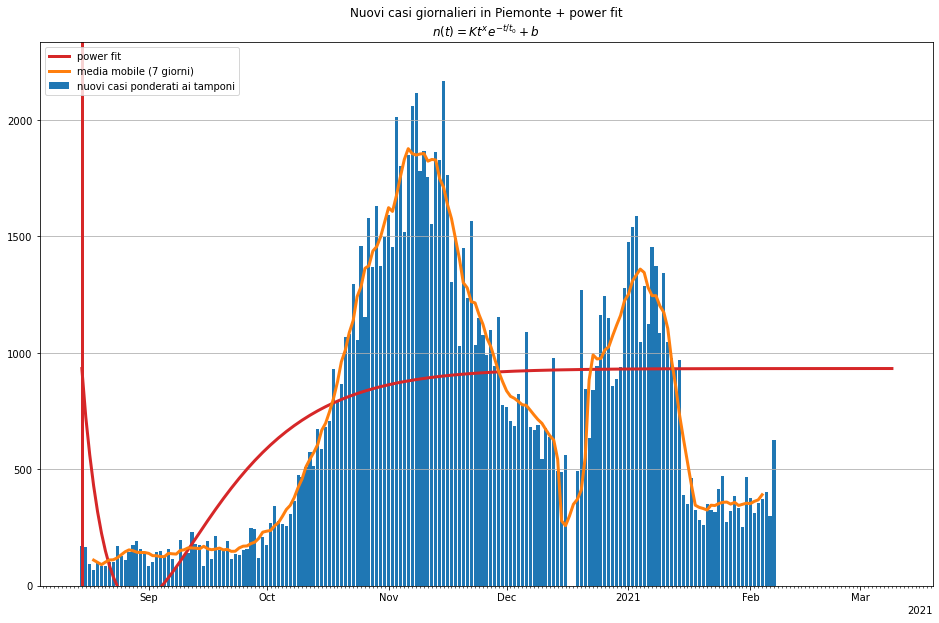

In [90]:
region = 'Piemonte'
normalized_new = get_normalized_new(region, start_day='2020-08-15')
# normalized_new = normalized_new[3:]
# normalized_new['2020-03-05'] = (normalized_new['2020-03-04'] + normalized_new['2020-03-06']) / 2
# normalized_new['2020-03-13'] = (normalized_new['2020-03-13'] + normalized_new['2020-03-14']) / 2
# normalized_new['2020-03-09'] = 0
fig, ax = plt.subplots(figsize=(16, 10))
normalized_new.name = 'nuovi casi ponderati ai tamponi'

casi = get_series(region, 'totale_casi')
observed = (casi - casi.shift())[1:].clip(0, np.inf)

popt, pcov, fit, argmax = show_fit(normalized_new, func, func_name, ax=ax, pred=30,
                                   title=f'Nuovi casi giornalieri in {region} + {func_name} '
                                         f'fit\n$n(t)=Kt^{{x}}e^{{-t/t_0}}+b$', window=7, 
                                   ma_color='tab:orange')
K, x, t0, b = popt
coefs['Piemonte casi_norm'] = popt
print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}, b = {b:.02f}')
print(f'first day: {normalized_new.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

In [91]:
region = 'Emilia-Romagna'
# deaths = get_series(region, 'deceduti')

# observed = (deaths - deaths.shift())[1:]
# popt, pcov, y = show_fit(observed, func, func_name, title=f'Nuovi deceduti giornalieri in {region} + {func_name} fit')
# K, x, t0 = popt
# coefs['Emilia-Romagna deceduti'] = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {observed.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {observed.index[np.argmax(y)]:%Y-%m-%d}')

Fit error: 821.49
Predicted volume error: -0.00%
Emilia-Romagna: K = -704.83426803, x = 0.69, t0 = 17.98
first day: 2020-09-01
peak as of fit: 2020-09-01


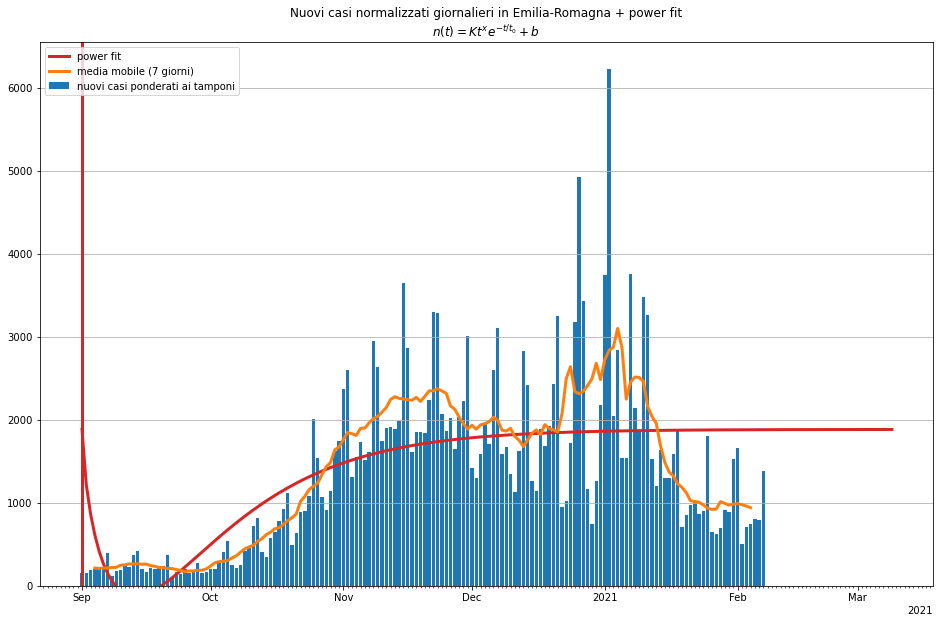

In [92]:
normalized_new = get_normalized_new(region, start_day='2020-09-01')
# normalized_new['2020-03-03'] = (normalized_new['2020-03-02'] + normalized_new['2020-03-04']) / 2
# normalized_new['2020-03-29'] = (normalized_new['2020-03-28'] + normalized_new['2020-03-30']) / 2
# normalized_new['2020-03-30'] = (normalized_new['2020-03-29'] + normalized_new['2020-03-31']) / 2
# normalized_new = normalized_new.clip(0)
normalized_new.name = 'nuovi casi ponderati ai tamponi'
fig, ax = plt.subplots(figsize=(16, 10))
popt, pcov, fit, argmax = show_fit(normalized_new, func, func_name, ax=ax,
                                   title=f'Nuovi casi normalizzati giornalieri in {region} + '
                                         f'{func_name} fit\n$n(t)=Kt^{{x}}e^{{-t/t_0}}+b$', window=7, pred=30)
K, x, t0, b = popt
coefs['Emilia-Romagna casi_norm'] = popt
print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
print(f'first day: {normalized_new.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

In [93]:
# casi = get_series(region, 'totale_casi')

# observed = (casi - casi.shift())[1:]
# popt, pcov, y = show_fit(observed, func, func_name, title=f'Nuovi casi giornalieri in {region} + {func_name} fit')
# K, x, t0 = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {observed.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {observed.index[np.argmax(y)]:%Y-%m-%d}')

In [94]:
# region = 'Puglia'
# deaths = get_series(region, 'deceduti')

# observed = (deaths - deaths.shift())[14:]
# popt, pcov, y = show_fit(observed, func, func_name, title=f'Nuovi deceduti giornalieri in {region} + {func_name} fit')
# K, x, t0 = popt
# coefs['Puglia deceduti'] = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {observed.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {observed.index[np.argmax(y)]:%Y-%m-%d}')

In [95]:
# casi = get_series(region, 'totale_casi')

# observed = (casi - casi.shift())[1:]
# popt, pcov, y = show_fit(observed, func, func_name, title=f'Nuovi casi giornalieri in {region} + {func_name} fit')
# K, x, t0 = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {observed.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {observed.index[np.argmax(y)]:%Y-%m-%d}')

In [96]:
# coefs_df = pd.DataFrame.from_records(coefs).T
# coefs_df.columns = ['K', 'x', 't0']
# coefs_df[coefs_df.index.to_series().str.endswith('casi_norm')]

In [97]:
# lombardia_deaths_viz.show_growth_factor(title='Tasso di crescita dei casi deceduti in Lombardia', 
#                                         sma=False, save_fig=True, save_csv=True, ylim=(0, 2))

## Casi in terapia intensiva in Lombardia

In [98]:
# lombardia_ti = regional_ds.df[regional_ds.df['denominazione_regione'] == 'Lombardia']['terapia_intensiva'].resample('D').last()
lombardia_ti.name = 'ti Lombardia'
lombardia_ti_viz = TimeSeriesViz(series=lombardia_ti, last_modified=regional_ds.last_modified)
lombardia_ti_viz.logger.setLevel(logging.INFO)

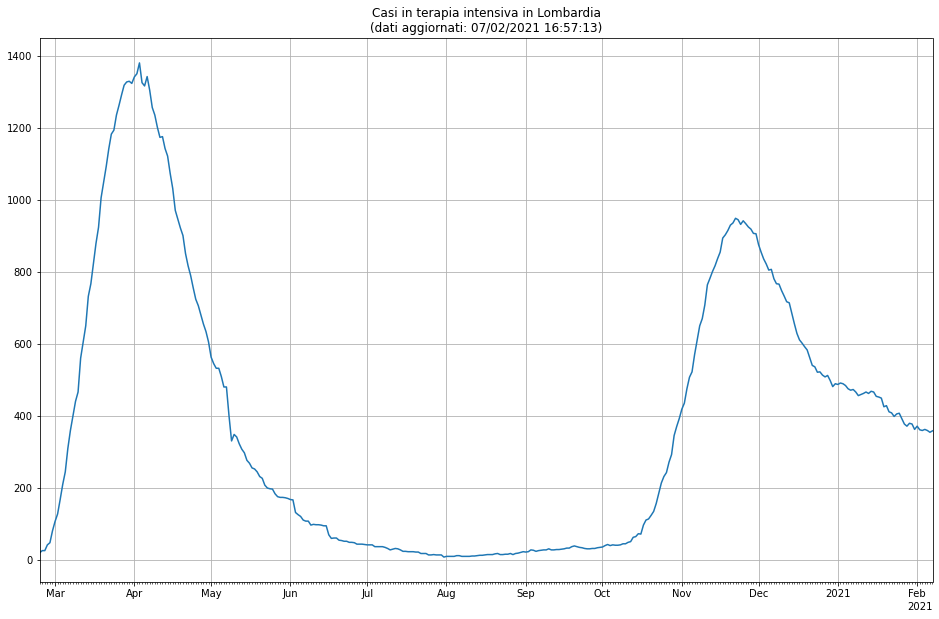

In [99]:
fig, ax = lombardia_ti_viz.show_series(title='Casi in terapia intensiva in Lombardia')
# ax.set_xlim(('2020-09-01', None))
# ax.set_ylim((0, 2000))

Fit error: 83.03
Predicted volume error: 0.00%
Peak as of fit: 2020-11-30 00:00:00
Peak value: 841


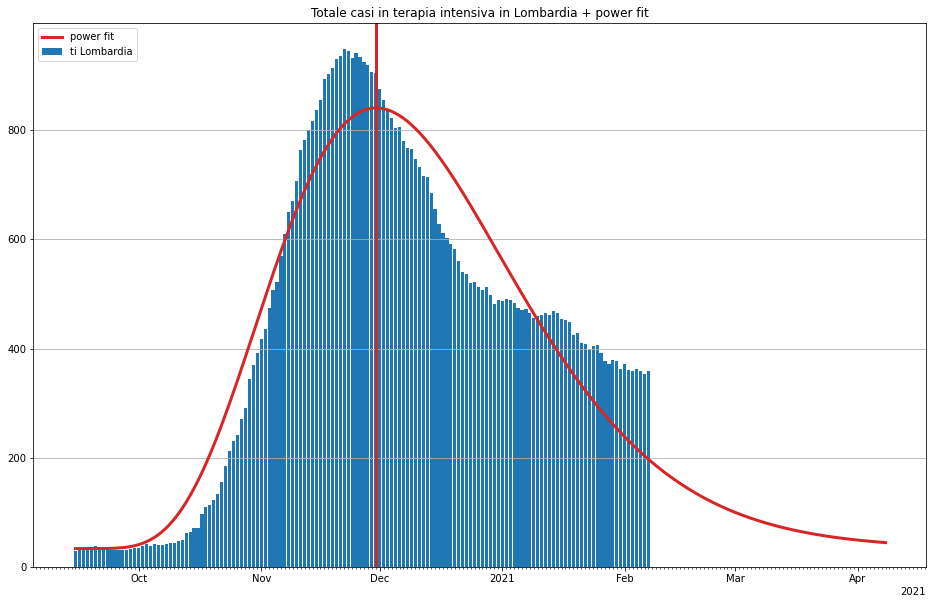

In [100]:
popt, pcov, fit, argmax = show_fit(lombardia_ti_viz.series['2020-09-15':], func, func_name, pred=60, 
                                   figsize=(16,10))
print('Peak as of fit:', argmax)
td = (argmax - pd.Timestamp('2020-09-15')).days
print('Peak value:', int(func(td, *popt)))
plt.title('Totale casi in terapia intensiva in Lombardia + power fit')
plt.show()

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi in terapia intensiva in Lombardia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

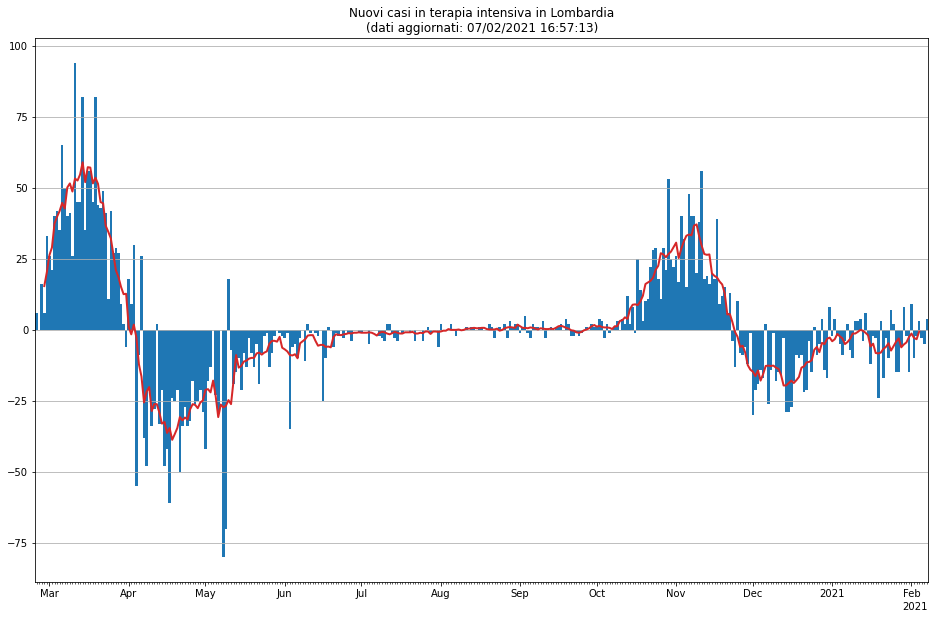

In [101]:
lombardia_ti_viz.show_new(title='Nuovi casi in terapia intensiva in Lombardia')

In [102]:
print('Nuovi casi giornalieri in TI in Lombardia:')
showdiff(lombardia_ti_viz.series).astype(int).to_frame()

Nuovi casi giornalieri in TI in Lombardia:


ti Lombardia
data                    
2021-01-29             8
2021-01-30            -2
2021-01-31           -15
2021-02-01             9
2021-02-02           -10
2021-02-03            -2
2021-02-04             3
2021-02-05            -3
2021-02-06            -5
2021-02-07             4

In [103]:
print('Totale casi in TI in Lombardia:')
lombardia_ti_viz.series.to_frame().tail(n=10)

Totale casi in TI in Lombardia:


ti Lombardia
data                    
2021-01-29           379
2021-01-30           377
2021-01-31           362
2021-02-01           371
2021-02-02           361
2021-02-03           359
2021-02-04           362
2021-02-05           359
2021-02-06           354
2021-02-07           358

In [104]:
lombardia_osp = regional_ds.df[regional_ds.df['denominazione_regione'] == 'Lombardia']['totale_ospedalizzati'].resample('D').last()
lombardia_osp.name = 'ospedalizzati Lombardia'
lombardia_osp_viz = TimeSeriesViz(series=lombardia_osp['2020--01':], last_modified=regional_ds.last_modified)
lombardia_osp_viz.logger.setLevel(logging.INFO)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Casi ospedalizzati in Lombardia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

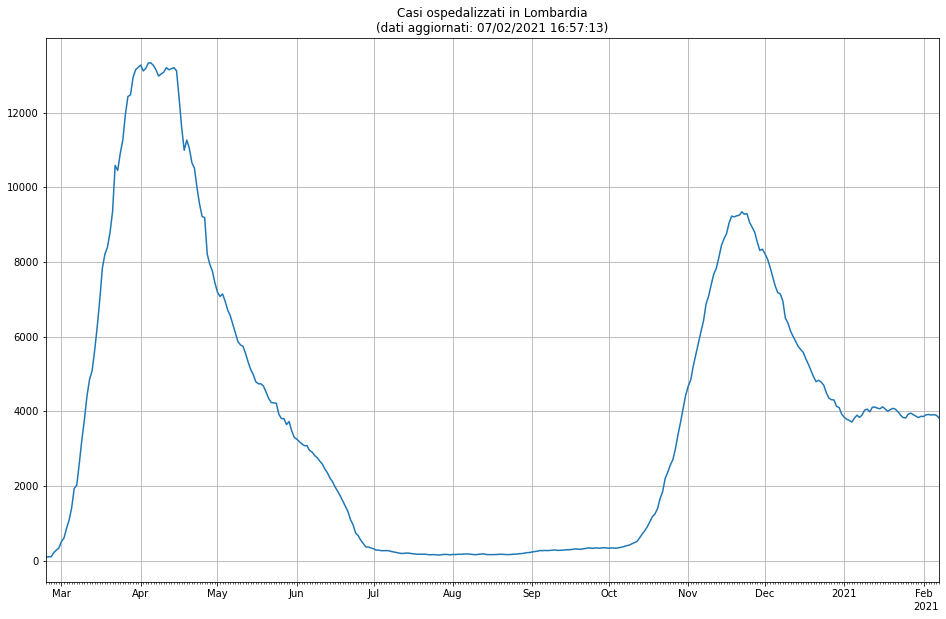

In [105]:
lombardia_osp_viz.show_series(title='Casi ospedalizzati in Lombardia')

In [106]:
print('Casi ospedalizzati in Lombardia:')
lombardia_osp_viz.series.tail(n=10)

Casi ospedalizzati in Lombardia:


data
2021-01-29    3869
2021-01-30    3831
2021-01-31    3865
2021-02-01    3860
2021-02-02    3905
2021-02-03    3913
2021-02-04    3901
2021-02-05    3908
2021-02-06    3894
2021-02-07    3825
Freq: D, Name: ospedalizzati Lombardia, dtype: int64

In [107]:
print('Nuovi casi giornalieri ospedalizzati in Lombardia:')
showdiff(lombardia_osp_viz.series, n=10).astype(int).to_frame()

Nuovi casi giornalieri ospedalizzati in Lombardia:


ospedalizzati Lombardia
data                               
2021-01-29                      -39
2021-01-30                      -38
2021-01-31                       34
2021-02-01                       -5
2021-02-02                       45
2021-02-03                        8
2021-02-04                      -12
2021-02-05                        7
2021-02-06                      -14
2021-02-07                      -69

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi ospedalizzati in Lombardia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

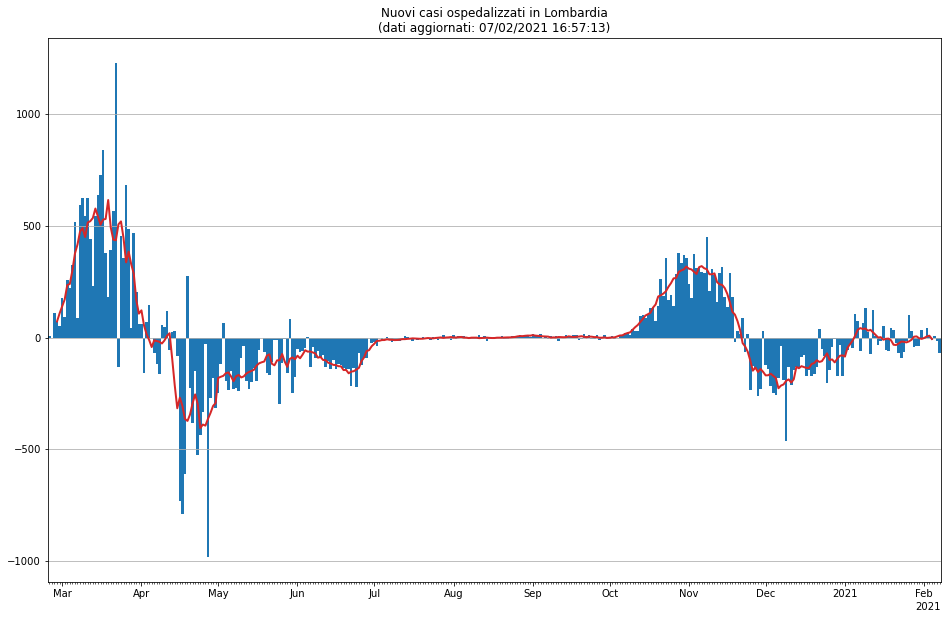

In [108]:
lombardia_osp_viz.show_new(title='Nuovi casi ospedalizzati in Lombardia')

# Dati delle province

In [109]:
%load_ext autoreload
%autoreload 2

In [110]:
provinces_ds = DataSet('dati-province/dpc-covid19-ita-province.csv')

def province_viz(provinces_ds, province_name):
    province_df = provinces_ds.df[provinces_ds.df['denominazione_provincia'] == province_name]
    province_tot = province_df['totale_casi'].resample('D').last()
    province_tot.name = province_name
    province_tot_viz = TimeSeriesViz(series=province_tot, last_modified=provinces_ds.last_modified)
    return province_tot_viz

def province_active_viz(provinces_ds, province_name, lookback=35):
    province_df = provinces_ds.df[provinces_ds.df['denominazione_provincia'] == province_name]
    province_tot = province_df['totale_casi'].resample('D').last()
    province_active = province_tot - province_tot.shift(lookback)
    province_active.name = province_name
    province_active_viz = TimeSeriesViz(series=province_active, last_modified=provinces_ds.last_modified)
    return province_active_viz

In [111]:
provinces_ds.df

stato  codice_regione denominazione_regione  \
data                                                              
2020-02-24 18:00:00   ITA              13               Abruzzo   
2020-02-24 18:00:00   ITA              13               Abruzzo   
2020-02-24 18:00:00   ITA              13               Abruzzo   
2020-02-24 18:00:00   ITA              13               Abruzzo   
2020-02-24 18:00:00   ITA              13               Abruzzo   
...                   ...             ...                   ...   
2021-02-07 17:00:00   ITA               5                Veneto   
2021-02-07 17:00:00   ITA               5                Veneto   
2021-02-07 17:00:00   ITA               5                Veneto   
2021-02-07 17:00:00   ITA               5                Veneto   
2021-02-07 17:00:00   ITA               5                Veneto   

                     codice_provincia               denominazione_provincia  \
data                                                                          
2020-02-24 18:00:00                66                              L'Aquila   
2020-02-24 18:00:00                67                                Teramo   
2020-02-24 18:00:00                68                               Pescara   
2020-02-24 18:00:00                69                                Chieti   
2020-02-24 18:00:00               979  In fase di definizione/aggiornamento   
...                               ...                                   ...   
2021-02-07 17:00:00                27                               Venezia   
2021-02-07 17:00:00                28                                Padova   
2021-02-07 17:00:00                29                                Rovigo   
2021-02-07 17:00:00               899    Fuori Regione / Provincia Autonoma   
2021-02-07 17:00:00               999  In fase di definizione/aggiornamento   

                    sigla_provincia        lat       long  totale_casi note  \
data                                                                          
2020-02-24 18:00:00              AQ  42.351222  13.398438            0  NaN   
2020-02-24 18:00:00              TE  42.658918  13.704400            0  NaN   
2020-02-24 18:00:00              PE  42.464584  14.213648            0  NaN   
2020-02-24 18:00:00              CH  42.351032  14.167546            0  NaN   
2020-02-24 18:00:00             NaN        NaN        NaN            0  NaN   
...                             ...        ...        ...          ...  ...   
2021-02-07 17:00:00              VE  45.434905  12.338452        50779  NaN   
2021-02-07 17:00:00              PD  45.406930  11.876087        58408  NaN   
2021-02-07 17:00:00              RO  45.071073  11.790070         9829  NaN   
2021-02-07 17:00:00             NaN        NaN        NaN         4295  NaN   
2021-02-07 17:00:00             NaN        NaN        NaN          571  NaN   

                    codice_nuts_1 codice_nuts_2 codice_nuts_3  
data                                                           
2020-02-24 18:00:00           NaN           NaN           NaN  
2020-02-24 18:00:00           NaN           NaN           NaN  
2020-02-24 18:00:00           NaN           NaN           NaN  
2020-02-24 18:00:00           NaN           NaN           NaN  
2020-02-24 18:00:00           NaN           NaN           NaN  
...                           ...           ...           ...  
2021-02-07 17:00:00           ITH          ITH3         ITH35  
2021-02-07 17:00:00           ITH          ITH3         ITH36  
2021-02-07 17:00:00           ITH          ITH3         ITH37  
2021-02-07 17:00:00           ITH          ITH3           NaN  
2021-02-07 17:00:00           ITH          ITH3           NaN  

[49588 rows x 13 columns]

In [112]:
province_df = provinces_ds.df
province_df[province_df['denominazione_regione'] == 'Lombardia']['denominazione_provincia'].unique()

array(['Varese', 'Como', 'Sondrio', 'Milano', 'Bergamo', 'Brescia',
       'Pavia', 'Cremona', 'Mantova', 'Lecco', 'Lodi',
       'Monza e della Brianza', 'In fase di definizione/aggiornamento',
       'Fuori Regione / Provincia Autonoma'], dtype=object)

In [113]:
df_pop_raw = pd.read_csv('data/popolazione_province_2019.csv')
df_pop_raw = df_pop_raw[['ITTER107', 'Territorio', 'Value']]
df_pop = df_pop_raw[df_pop_raw['ITTER107'].str.len() == 5]

In [114]:
def show_gr_prev(province_df, df_pop, region=False, gr_days=7, ms=10, show_trait=1, active_days=14,
                 prevalence_nom = 100000, figsize=(16, 10), xlim=(None, None), ylim=(None, None), window=1):
    region_df = province_df[province_df['denominazione_regione'] == region] if region else province_df
    provinces = region_df['denominazione_provincia'].unique()
    provinces = [p for p in provinces if not p.startswith('In fase di')]
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(0, color='lightgray', linestyle='--')
    
    region_pop = 0
    for province in provinces:
        data = province_df[province_df['denominazione_provincia'] == province]
        pop = df_pop[df_pop['Territorio'] == province]['Value'].sum()
        region_pop += pop
        cases = data['totale_casi'].rolling(window).mean()
        active_cases = cases - cases.shift(active_days)
        active_start = active_cases.shift(gr_days)
        growth_rate = (((active_cases - active_start) / active_start) * 100)
        prevalence = ((active_cases / pop) * prevalence_nom)
        marker = 'o' if show_trait <= 1 else None
        province_plot = ax.plot(prevalence[-show_trait:], growth_rate[-show_trait:], 
                                marker=marker, linestyle='-', ms=ms, label=province)
        province_color = province_plot[0].get_color()
        ax.annotate(province, (prevalence[-1], growth_rate[-1]), xytext=(ms/2, ms/2), 
                    textcoords='offset points', color=province_color, size=13)

    if region:
        region_data = region_df.groupby(region_df.index).sum()
        region_cases = region_data['totale_casi'].rolling(window).mean()
        active_cases = region_cases - region_cases.shift(active_days)
        active_start = active_cases.shift(gr_days)
        region_gr = (((active_cases - active_start) / active_start) * 100)
        region_prevalence = ((active_cases / region_pop) * prevalence_nom)
        region_plot = ax.plot(region_prevalence[-show_trait:], region_gr[-show_trait:], 
                              linestyle='-', lw=4, ms=ms, label=region)
        region_color = region_plot[0].get_color()
        if show_trait == 1:
            ax.axvline(region_prevalence[0], c=region_color)
            ax.axhline(region_gr[0], c=region_color)
        ax.annotate(region, (region_prevalence[-1], region_gr[-1]), xytext=(5, 5), 
                    textcoords='offset points', color=region_color, size=13)
        ax.legend()
    ax.set_ylabel(f'growth rate (last {gr_days} days)')
    ax.set_xlabel(f'prevalence (active cases / {prevalence_nom} individuals)')
    title = f'Growth rate and prevalence for {region}, {cases.index[-1]:%Y-%m-%d}' \
            if region else f'Growth rate and prevalence for Italy, {cases.index[-1]:%Y-%m-%d}'
    ax.set_title(title)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=1))
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

In [115]:
gr_days = 7

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


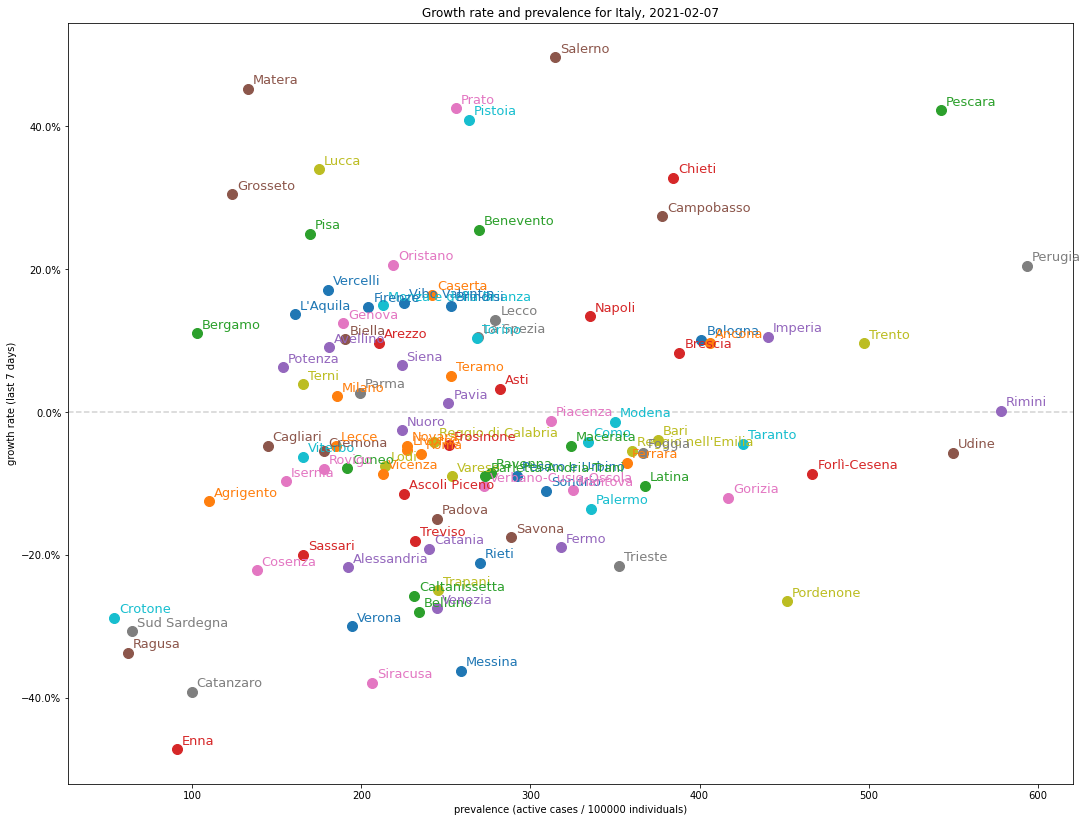

In [116]:
show_gr_prev(province_df, df_pop, gr_days=gr_days, show_trait=1, figsize=(18, 14))

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


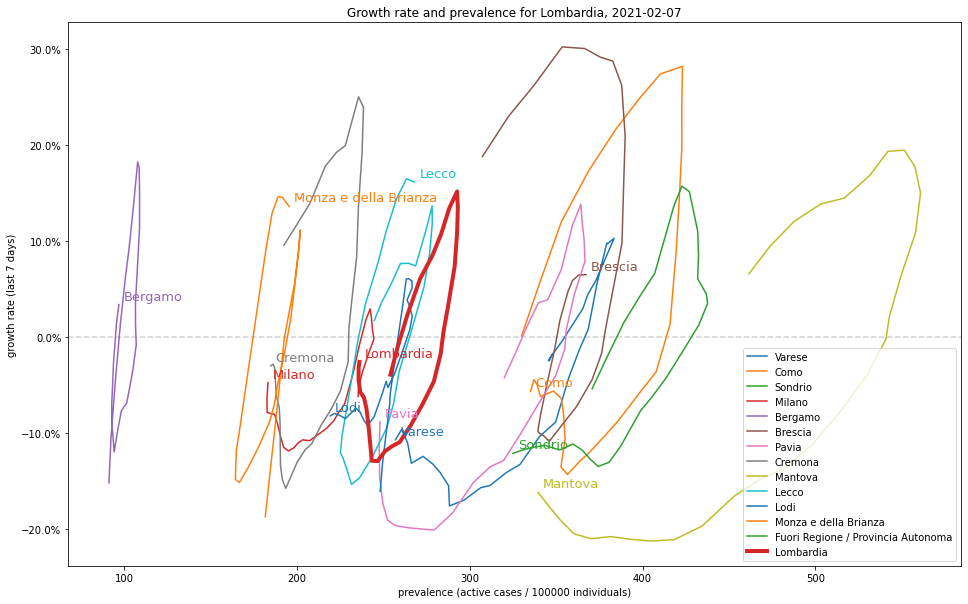

In [167]:
show_gr_prev(province_df, df_pop, 'Lombardia', gr_days=gr_days, show_trait=30, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


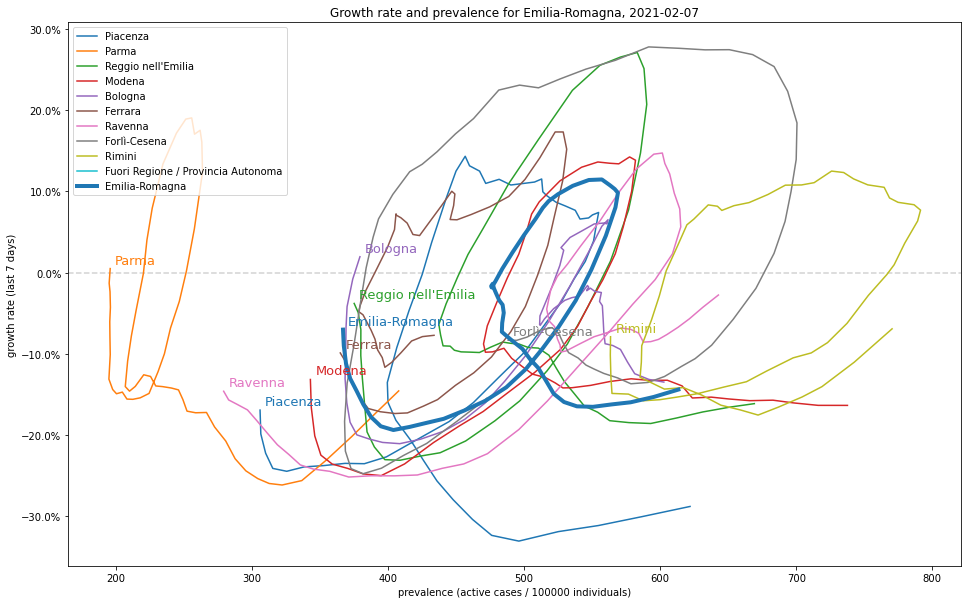

In [118]:
show_gr_prev(province_df, df_pop, 'Emilia-Romagna', gr_days=gr_days, show_trait=60, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


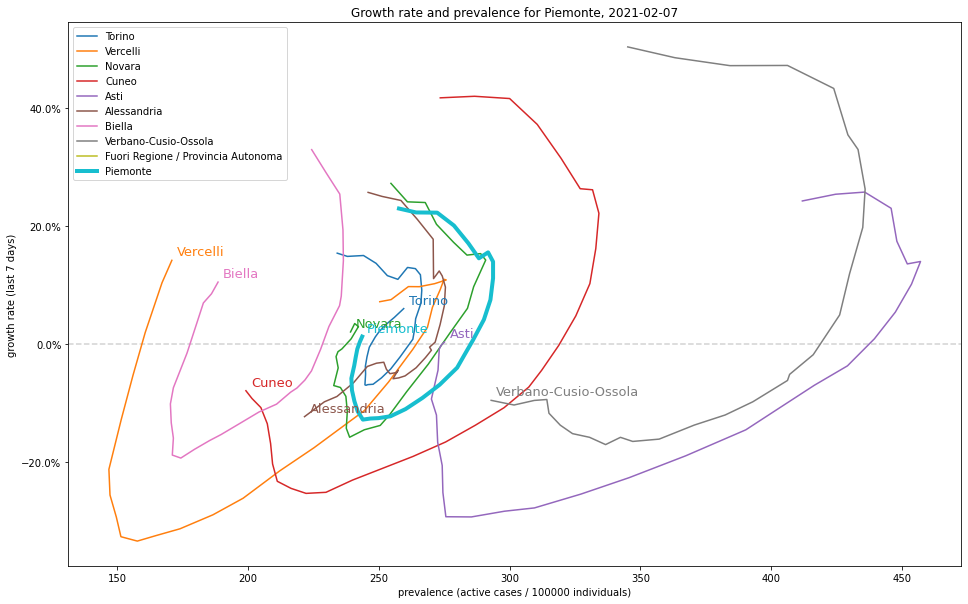

In [119]:
show_gr_prev(province_df, df_pop, 'Piemonte', gr_days=gr_days, show_trait=30, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


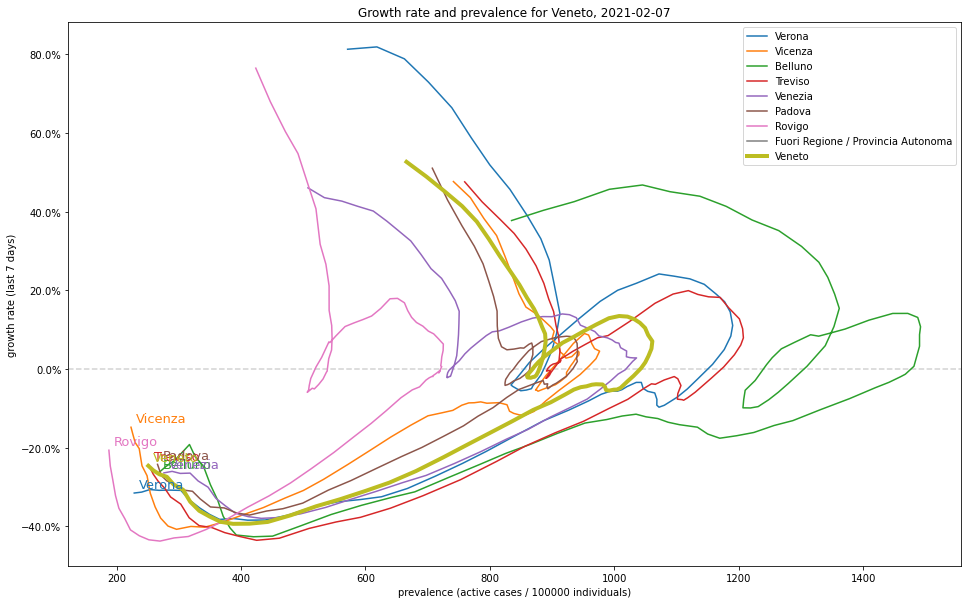

In [120]:
show_gr_prev(province_df, df_pop, 'Veneto', gr_days=gr_days, show_trait=90, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


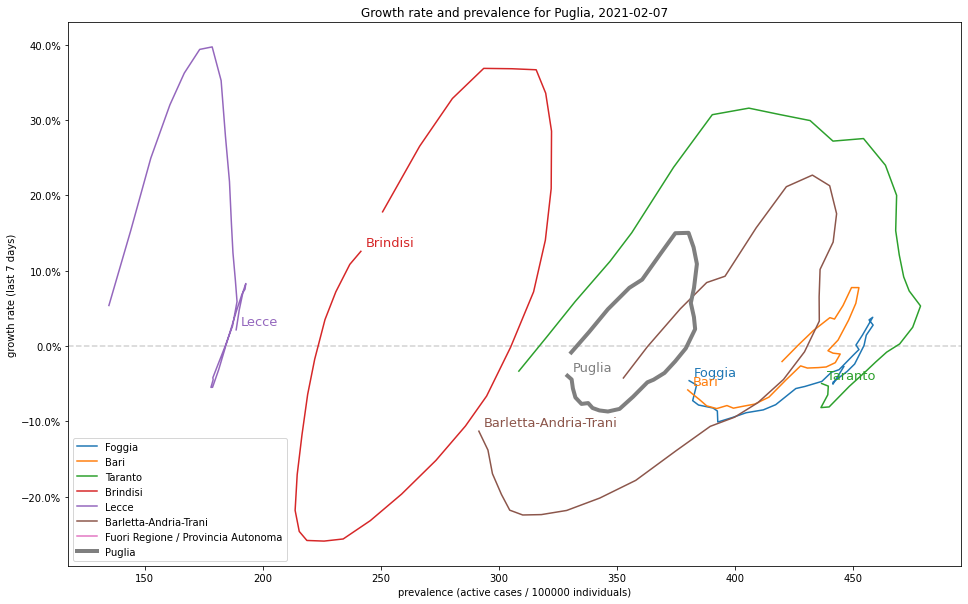

In [121]:
show_gr_prev(province_df, df_pop, 'Puglia',  gr_days=gr_days, show_trait=30, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


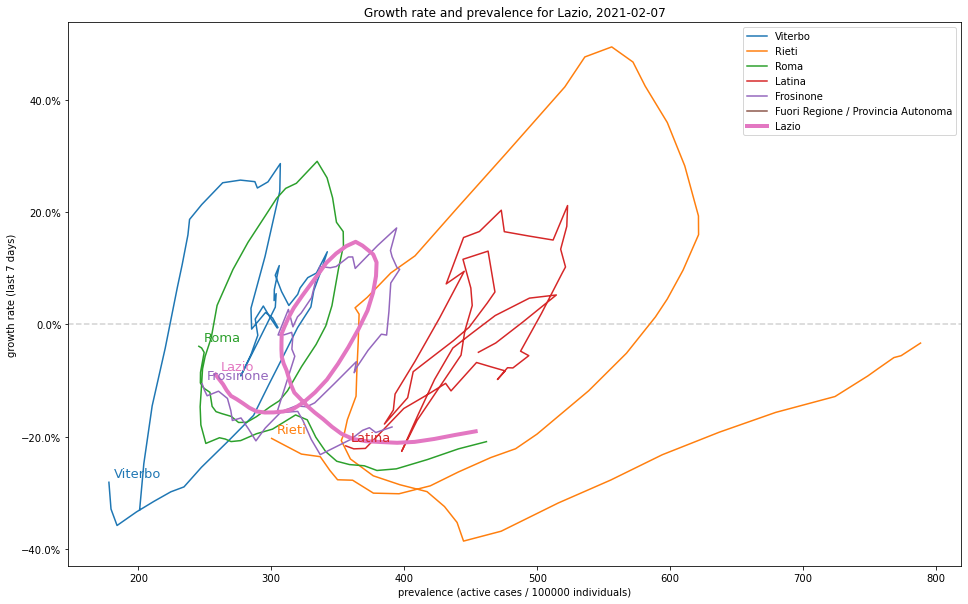

In [122]:
show_gr_prev(province_df, df_pop, 'Lazio',  gr_days=gr_days, show_trait=60, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


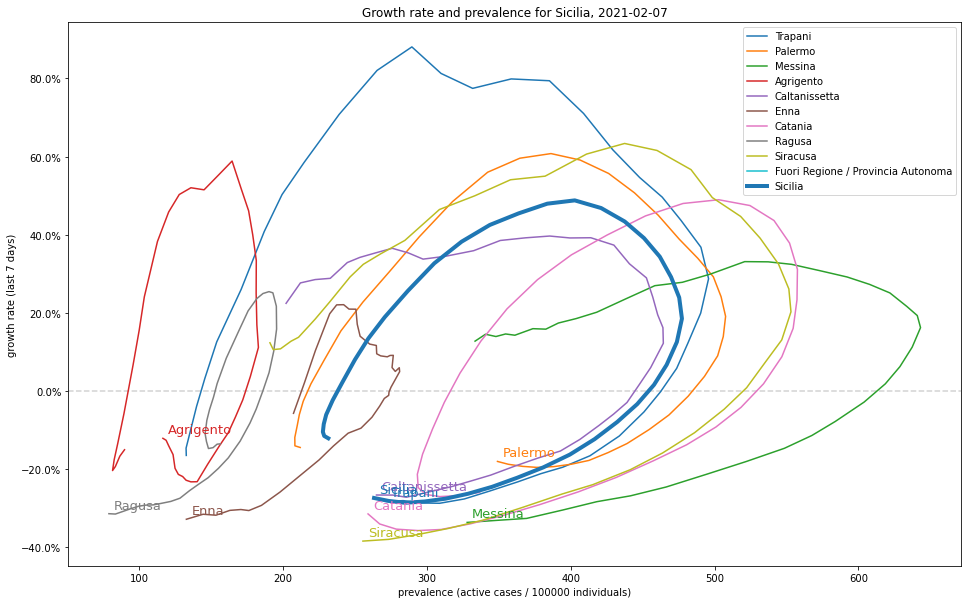

In [123]:
show_gr_prev(province_df, df_pop, 'Sicilia',  gr_days=gr_days, show_trait=40, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


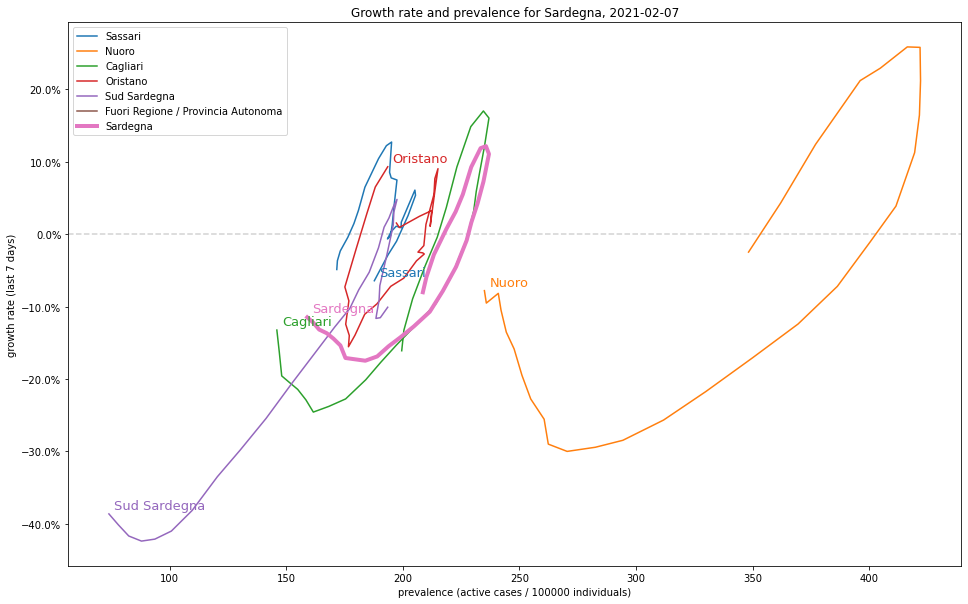

In [124]:
show_gr_prev(province_df, df_pop, 'Sardegna', gr_days=gr_days, show_trait=30, window=7)

/Users/janos/anaconda/envs/workspace/lib/python3.7/site-packages/matplotlib/transforms.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


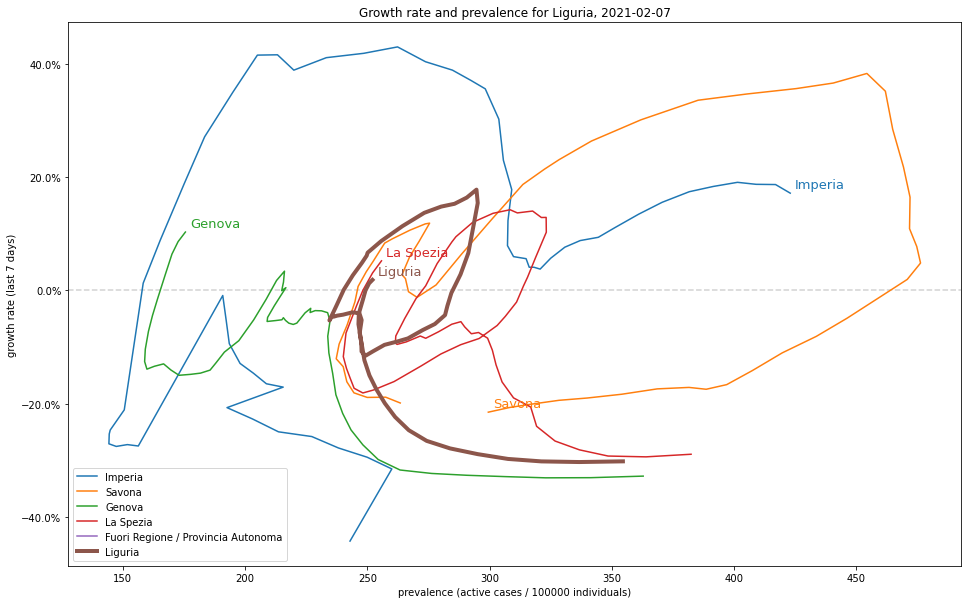

In [125]:
show_gr_prev(province_df, df_pop, 'Liguria', gr_days=gr_days, show_trait=60, window=7)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Casi totali nella provincia di Milano\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

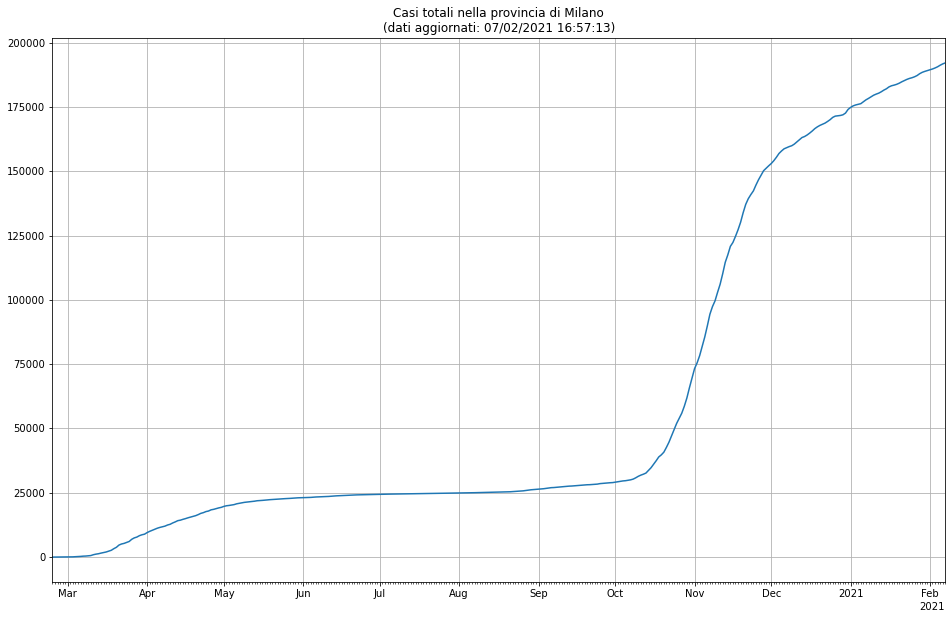

In [126]:
province_name = 'Milano'
milano_tot_viz = province_viz(provinces_ds, province_name)
milano_tot_viz.show_series(title=f'Casi totali nella provincia di {province_name}')

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Casi attivi nella provincia di Milano\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

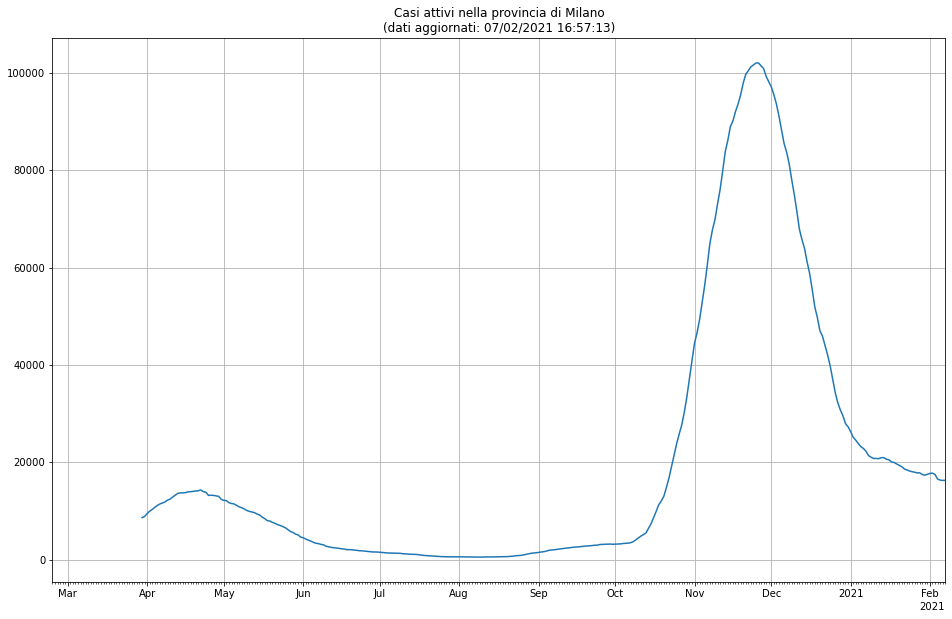

In [127]:
province_name = 'Milano'
milano_active_viz = province_active_viz(provinces_ds, province_name)
milano_active_viz.show_series(title=f'Casi attivi nella provincia di {province_name}')

(array(18506.), 18665.5)

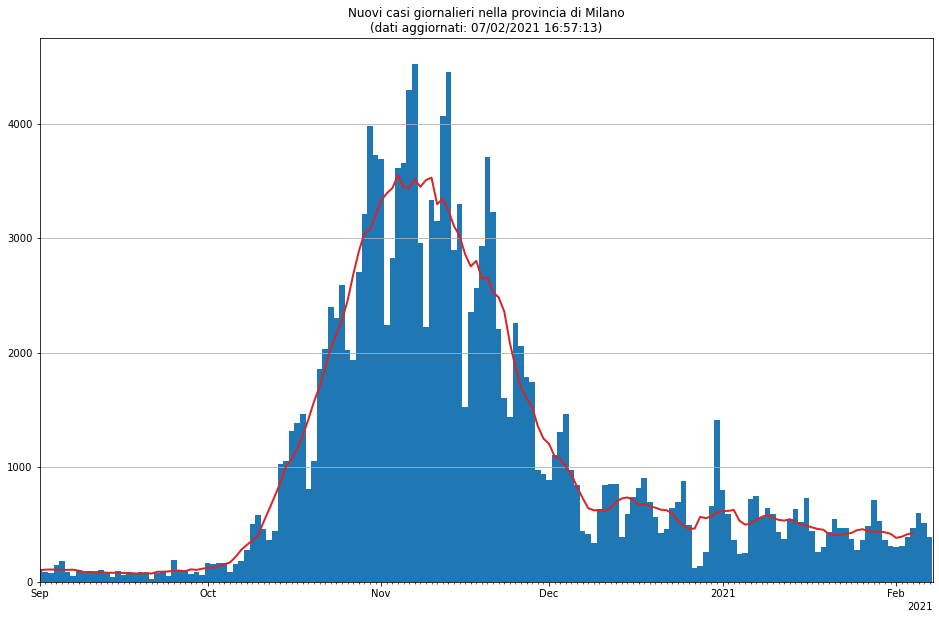

In [128]:
fig, ax = milano_tot_viz.show_new(title=f'Nuovi casi giornalieri nella provincia di Milano')
ax.set_xlim(('2020-09-01', None))

In [129]:
milano_2d = (milano_tot_viz.series - milano_tot_viz.series.shift()).resample('2D').sum().expanding().sum()
milano_2d_viz = TimeSeriesViz(milano_2d, datetime.now())
# milano_2d_viz.show_growth_factor(title=f'Tasso di crescita dei casi a Milano (2 days)', window=4)

In [130]:
province_name = 'Milano'
milano_tot_viz.show_growth_factor(title=f'Tasso di crescita dei casi a {province_name}', 
                                  raw=True, sma=True, ema=False, window=7)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Tasso di crescita dei casi a Milano\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

In [131]:
milano_tot = milano_tot_viz.series
observed = (milano_tot - milano_tot.shift())['2020-09-01':]
popt, pcov, y, argmax = show_fit(observed, func, func_name, 
                                 title=f'Nuovi casi giornalieri in Milano + {func_name} fit', 
                                 window=7, figsize=(16, 10))
K, x, t0, b = popt
print(f'Milano: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}, b = {b:.02f}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

Fit error: 385.00
Predicted volume error: 0.00%
Milano: K = 0.00000000, x = 22.54, t0 = 2.96, b = 317.96
peak as of fit: 2020-11-07


In [132]:
province_name = 'Bergamo'
bergamo_tot_viz = province_viz(provinces_ds, province_name)
# bergamo_tot_viz.show_series(title=f'Casi totali nella provincia di {province_name}', save_fig=True, save_csv=True)

In [133]:
bergamo_tot_viz.show_new(title=f'Nuovi casi giornalieri nella provincia di {province_name}')

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi giornalieri nella provincia di Bergamo\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

In [134]:
(bergamo_tot_viz.series - bergamo_tot_viz.series.shift()).tail()

data
2021-02-03     81.0
2021-02-04    146.0
2021-02-05    124.0
2021-02-06    146.0
2021-02-07     50.0
Freq: D, Name: Bergamo, dtype: float64

Fit error: 57.17
Predicted volume error: 0.00%
Bergamo: K = 0.00000002, x = 8.52, t0 = 4.76
first day: 2020-10-01
peak as of fit: 2020-11-11


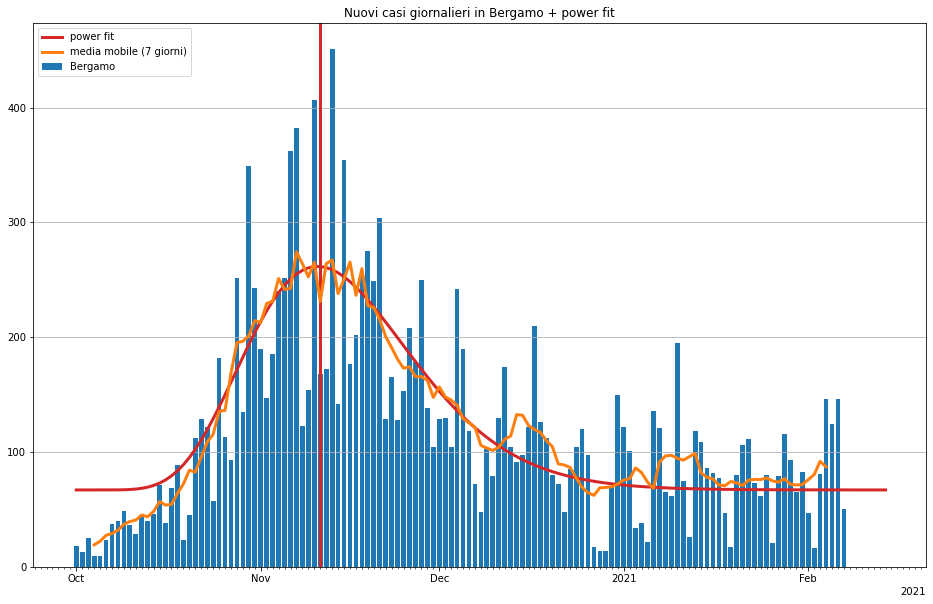

In [135]:
province = 'Bergamo'
observed = (bergamo_tot_viz.series - bergamo_tot_viz.series.shift())['2020-10-01':]
popt, pcov, y, argmax = show_fit(observed, func, func_name, 
                                 title=f'Nuovi casi giornalieri in {province} + {func_name} fit',
                                 window=7, figsize=(16, 10))
K, x, t0, b = popt
print(f'{province}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
print(f'first day: {observed.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

In [136]:
# bergamo_tot_viz.show_growth_factor(title=f'Tasso di crescita dei casi a {province_name}', sma=False, save_fig=True, save_csv=True, ylim=(0, 5))

In [137]:
province_name = 'Brescia'
brescia_tot_viz = province_viz(provinces_ds, province_name)
# brescia_tot_viz.show_series(title=f'Casi totali nella provincia di {province_name}', save_fig=True, save_csv=True)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi giornalieri nella provincia di Brescia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

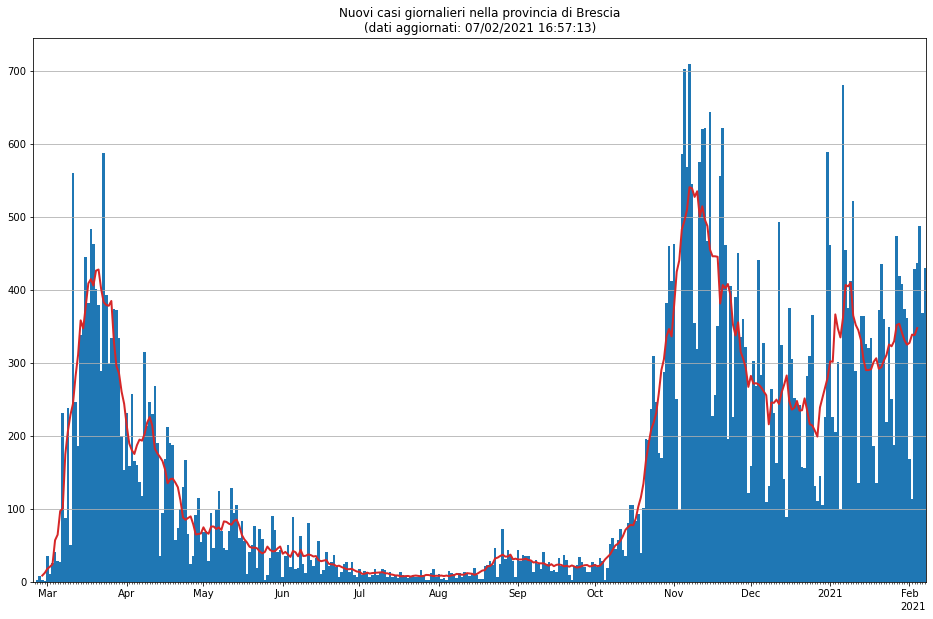

In [138]:
brescia_tot_viz.show_new(title=f'Nuovi casi giornalieri nella provincia di {province_name}')

Fit error: 147.08
Predicted volume error: 0.00%
Brescia: K = 34.68337375, x = 0.80, t0 = 77.71
first day: 2020-10-01
peak as of fit: 2020-12-02


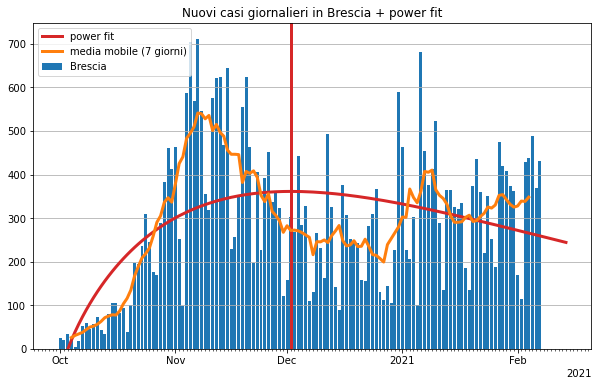

In [139]:
province = 'Brescia'
observed = (brescia_tot_viz.series - brescia_tot_viz.series.shift())['2020-10-01':]
popt, pcov, y, argmax = show_fit(observed, func, func_name, window=7,
                            title=f'Nuovi casi giornalieri in {province} + {func_name} fit')
K, x, t0, b = popt
print(f'{province}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
print(f'first day: {observed.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

In [140]:
# brescia_tot_viz.show_growth_factor(title=f'Tasso di crescita dei casi a {province_name}', 
#                                    sma=False, save_fig=True, save_csv=True, ylim=(0, 5))

# Dati nazionali
## Casi totali in Italia

In [141]:
national_totale = national.df['totale_casi']
national_totale.name = 'totali Italia'
national_all_viz = TimeSeriesViz(series=national_totale, last_modified=national.last_modified)
national_all_viz.logger.setLevel(logging.INFO)

In [142]:
national_totale.tail()

data
2021-02-03    2583790
2021-02-04    2597446
2021-02-05    2611659
2021-02-06    2625098
2021-02-07    2636738
Freq: D, Name: totali Italia, dtype: int64

In [143]:
# national_all_viz.show_series(title='Casi totali in Italia', save_fig=True, save_csv=True)

data
2021-02-03    13182.0
2021-02-04    13656.0
2021-02-05    14213.0
2021-02-06    13439.0
2021-02-07    11640.0
Freq: D, Name: totali Italia, dtype: float64


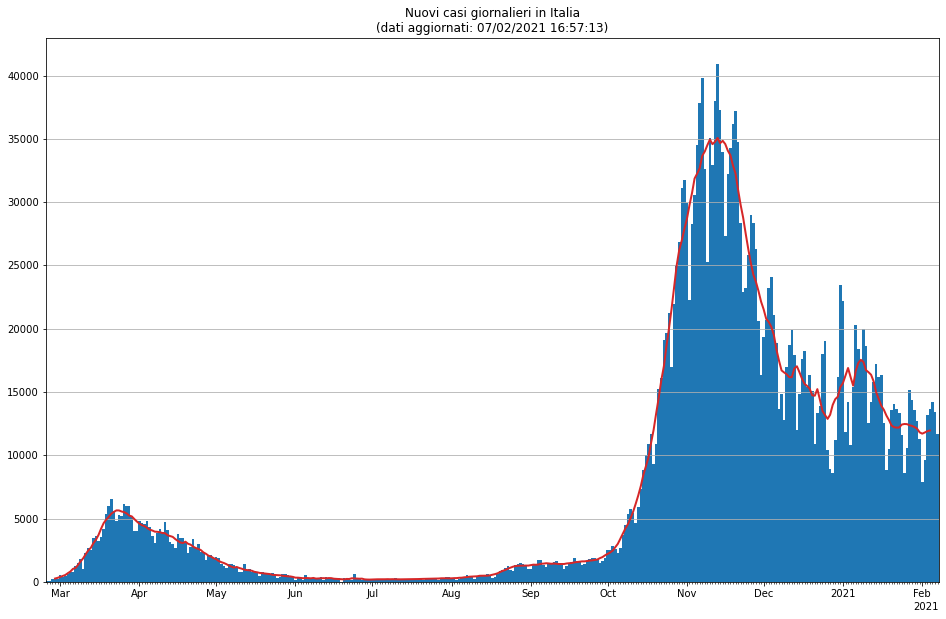

In [144]:
national_all_viz.show_new(title='Nuovi casi giornalieri in Italia', zero_min=True)
print((national_all_viz.series - national_all_viz.series.shift()).tail())

Fit error: 4457.06
Predicted volume error: 0.00%
Italia: K = 0.03502537, x = 3.75, t0 = 24.79
first day: 2020-09-01
peak as of fit: 2020-12-03


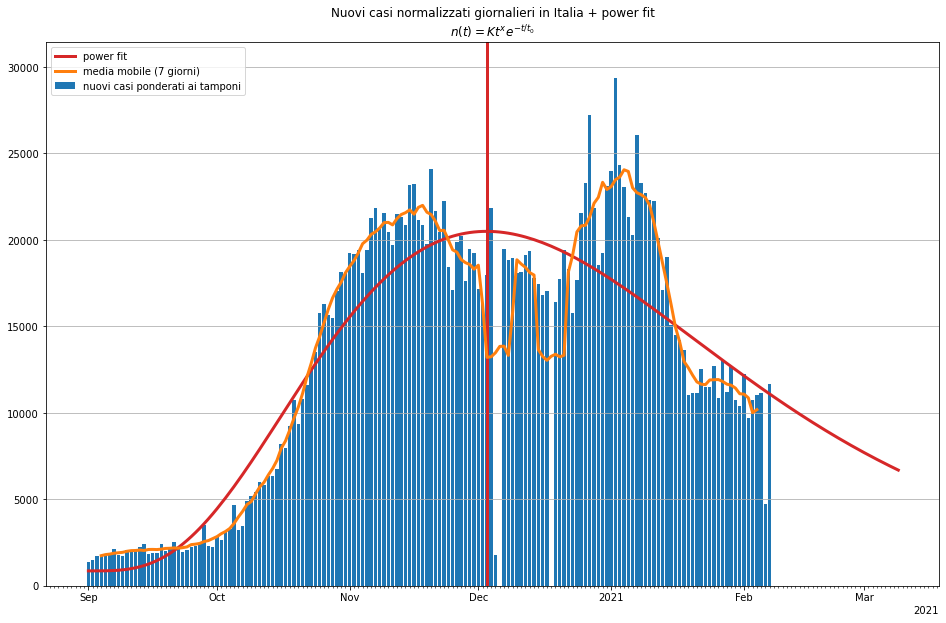

In [145]:
total = national.df['totale_casi']
tests = national.df['casi_testati']
diff_total = (total - total.shift())
diff_tests = (tests - tests.shift())
normalized = (diff_total / (diff_tests / diff_tests[-1]))['2020-09-01':]
normalized.name = 'nuovi casi ponderati ai tamponi'
popt, pcov, fit, argmax = show_fit(normalized, func, func_name, pred=30, figsize=(16, 10),
                                   title=f'Nuovi casi normalizzati giornalieri in Italia + {func_name} fit\n'
                                         f'$n(t)=Kt^{{x}}e^{{-t/t_0}}$',
                                   window=7)
K, x, t0, b = popt
print(f'Italia: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
print(f'first day: {normalized.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

In [146]:
observed = (national_totale - national_totale.shift())['2020-09-01':]
popt, pcov, y, argmax = show_fit(observed, func, func_name, 
                                 title=f'Nuovi casi giornalieri in Italia + {func_name} fit', 
                                 figsize=(16, 10), pred=15, window=7)
K, x, t0, b = popt
print(f'Italia: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
print(f'first day: {observed.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

Fit error: 5165.13
Predicted volume error: 0.00%
Italia: K = 0.00000045, x = 7.41, t0 = 10.40
first day: 2020-09-01
peak as of fit: 2020-11-17


In [147]:
observed

data
2020-09-01      975.0
2020-09-02     1326.0
2020-09-03     1397.0
2020-09-04     1732.0
2020-09-05     1693.0
               ...   
2021-02-03    13182.0
2021-02-04    13656.0
2021-02-05    14213.0
2021-02-06    13439.0
2021-02-07    11640.0
Freq: D, Name: totali Italia, Length: 160, dtype: float64

In [148]:
# total = national.df['totale_casi']
# tests = national.df['tamponi']
# diff_total = (total - total.shift())
# diff_tests = (tests - tests.shift())
# normalized_total = (diff_total / (diff_tests / diff_tests.max()))[1:]
# normalized_total['2020-03-09'] = (normalized_total['2020-03-08'] + normalized_total['2020-03-10']) / 2
# normalized_new.name = 'nuovi casi ponderati ai tamponi'
# popt, pcov, fit = show_fit(normalized_new, func, func_name,
#                          title=f'Nuovi casi normalizzati giornalieri in Italia + {func_name} fit\n$n(t)=Kt^{{x}}e^{{-t/t_0}}$')
# K, x, t0 = popt
# print(f'{region}: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
# print(f'first day: {normalized_new.index[0]:%Y-%m-%d}')
# print(f'peak as of fit: {normalized_new.index[np.argmax(fit)]:%Y-%m-%d}')

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Tasso di crescita per i casi totali in Italia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

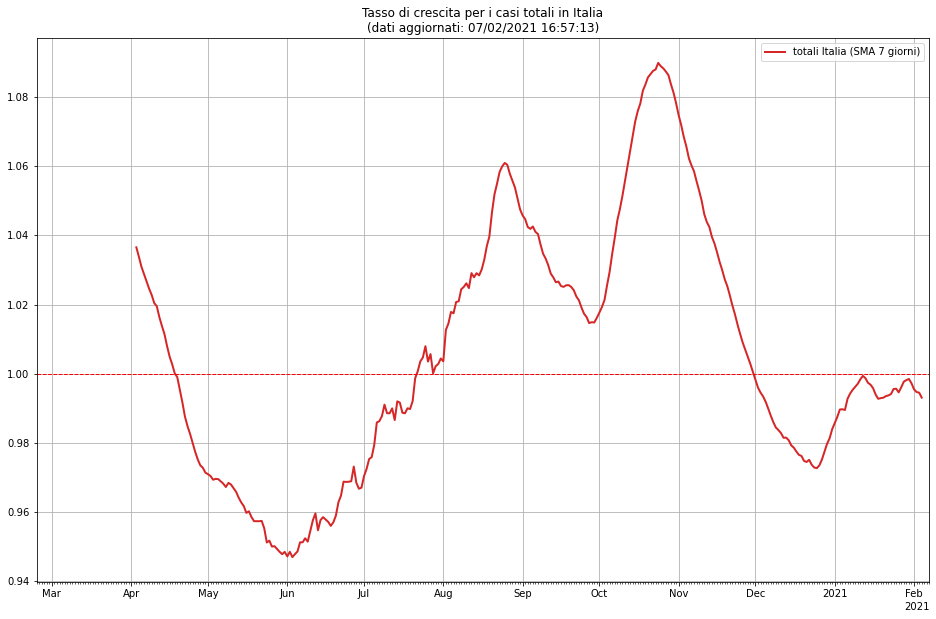

In [149]:
national_all_viz.show_growth_factor(title='Tasso di crescita per i casi totali in Italia', 
                                    raw=False, sma=True, ema=False, window=7)

## Casi decessi in Italia

In [150]:
deaths = national.df['deceduti']
deaths.name = 'deceduti Italia'
deaths_viz = TimeSeriesViz(series=deaths, last_modified=national.last_modified)
deaths_viz.logger.setLevel(logging.INFO)

In [151]:
# deaths_viz.show_series(title='Casi deceduti in Italia', save_fig=True, save_csv=True)

In [152]:
# deaths_viz.show_new(title='Nuovi casi deceduti in Italia', save_fig=True, save_csv=True)

In [153]:
observed = (deaths - deaths.shift())['2020-10-01':]
popt, pcov, y, argmax = show_fit(observed, func, func_name, pred=14,
                                 title=f'Nuovi deceduti giornalieri in Italia + {func_name} fit', 
                                 figsize=(16, 10), window=7)
K, x, t0, b = popt
print(f'Italia: K = {K:.08f}, x = {x:.02f}, t0 = {t0:.02f}')
print(f'first day: {observed.index[0]:%Y-%m-%d}')
print(f'peak as of fit: {argmax:%Y-%m-%d}')

Fit error: 110.84
Predicted volume error: 0.00%
Italia: K = 0.04994824, x = 2.97, t0 = 22.46
first day: 2020-10-01
peak as of fit: 2020-12-07


In [154]:
observed.tail()

data
2021-02-03    476.0
2021-02-04    422.0
2021-02-05    377.0
2021-02-06    385.0
2021-02-07    270.0
Freq: D, Name: deceduti Italia, dtype: float64

In [155]:
# deaths_viz.show_growth_factor(title='Tasso di crescita dei deceduti in Italia', sma=False, save_fig=True, save_csv=True)

## Casi in terapia intensiva in Italia

In [156]:
ti = national.df['terapia_intensiva']
ti.name = 'ti Italia'
ti_viz = TimeSeriesViz(series=ti, last_modified=national.last_modified)
ti_viz.logger.setLevel(logging.INFO)

In [157]:
ti_viz.show_series(title='Casi in terapia intensiva in Italia')

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Casi in terapia intensiva in Italia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi in terapia intensiva in Italia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

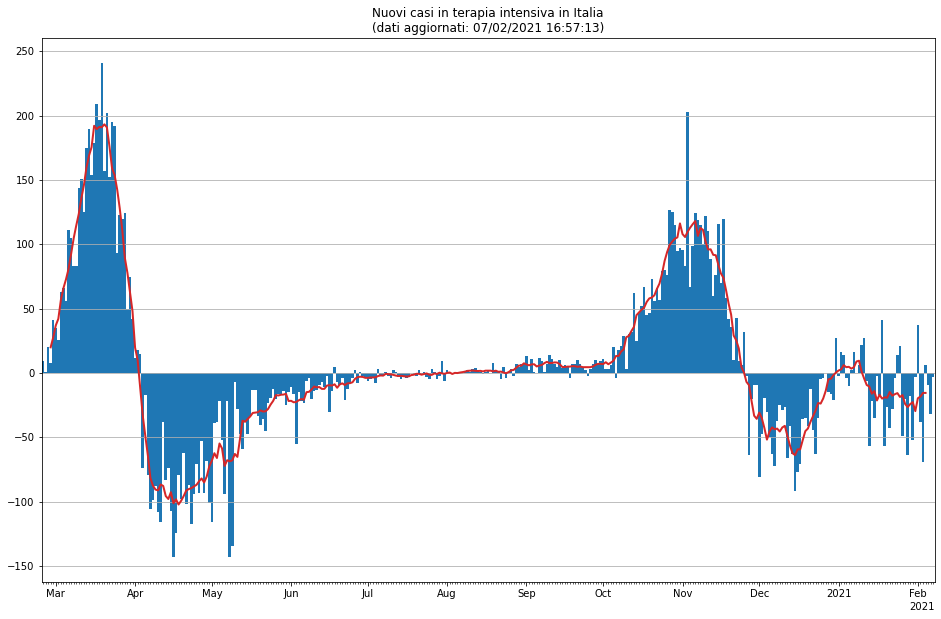

In [158]:
ti_viz.show_new(title='Nuovi casi in terapia intensiva in Italia')

In [159]:
all_serious = national.df['ricoverati_con_sintomi'] +  national.df['terapia_intensiva']
all_serious.name = 'tutti casi seri Italia'
all_serious_viz = TimeSeriesViz(series=all_serious, last_modified=national.last_modified)
all_serious_viz.logger.setLevel(logging.INFO)

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Tutti casi seri (ricoverati + ti) in Italia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

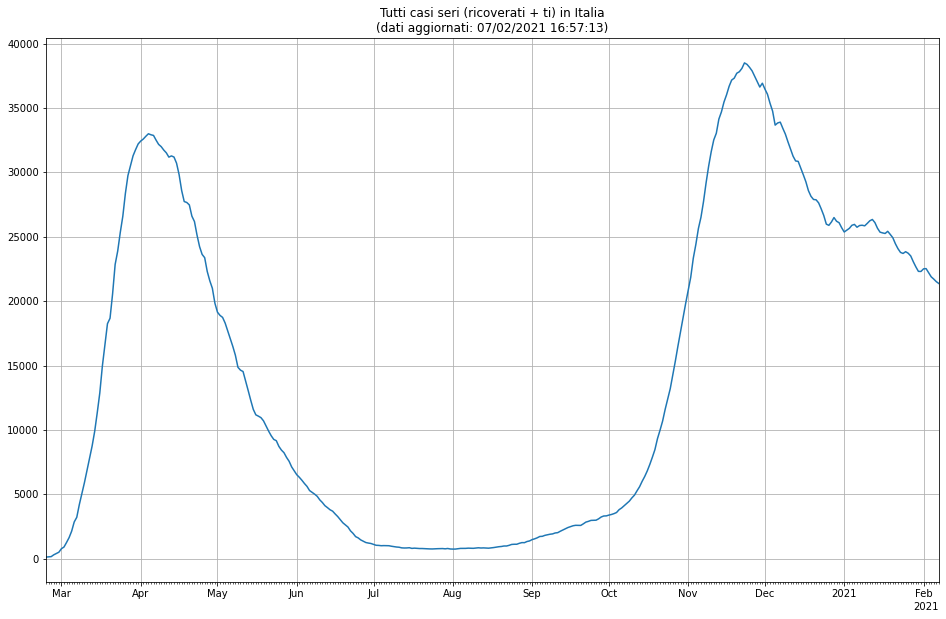

In [160]:
all_serious_viz.show_series(title='Tutti casi seri (ricoverati + ti) in Italia')

In [161]:
all_serious_viz.show_new(title='Nuovi casi seri (ricoverati + ti) in Italia')

(<Figure size 1152x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Nuovi casi seri (ricoverati + ti) in Italia\n(dati aggiornati: 07/02/2021 16:57:13)'}>)

In [162]:
# regions_df_totale = regional_ds.df.pivot(columns='denominazione_regione', values='totale_casi').resample('D').last()
# regions_df_totale_diff = (regions_df_totale - regions_df_totale.shift())
# selected_regions = ['Lombardia', 'Emilia Romagna', 'Veneto']
# selected_regions = ['Lombardia']
# show_gr(regions_df_totale_diff[selected_regions], raw=True, sma=False, ema=True,
#         title=f'Tasso di cressita dei casi totali in alcuni Regioni\n'a
#               f'(dati aggiornati: {regional_ds.last_modified:%d/%m/%Y %H:%M:%S})')